# Autoencoder_Ensemble_Net

## Importing necessary libraries and setting environ variables

In [2]:
import os
import sys
import time
import math
import random
import numpy as np
import matplotlib.pylab as plt

# Try importing tqdm notebook
try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError as e:
    print('tdqm.notebook not found. Try updating tdqm. Reverting to base tqdm', e)
    import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import joblib
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import hinge_loss, log_loss
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import auc, roc_curve

# CUSTOM IMPORTS

# utility functions
from src.utils import get_train_test_split_from_npy, get_X_y_from_npy, count_unique_labels
from src.utils import chamfer_loss, visualize_npy, print_model_metrics, HyperParameter, DirectorySetting

# models
from src.models import AutoDecoder, EnsembleAutoDecoder, CompNet, EnsembleCompNet

# datasets
from src.datasets import PointDriftDS, EncodingDS, PointNetDS

# train and test modules
from src.trainer import return_decoder_train_test_encoding_ds
from src.trainer import find_encoding, train_decoder, eval_decoder, train_compnet, eval_compnet

from src.trainer import train_svm, train_decision_trees, train_log_regr, train_naive_bayes, train_rand_forest
from src.trainer import eval_svm, eval_decision_trees, eval_log_regr, eval_gaussian_naive_bayes, eval_rand_forest

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

tdqm.notebook not found. Try updating tdqm. Reverting to base tqdm No module named 'tqdm.notebook'


## GPU Device Configuration

Then, we set up and configure our computational devices: Whether we use GPU or perform the calculation on CPU. we use the torch.devices() and torch.cude.is_available() functions to configure our computational devices

**Note: GPU Training is required**

In [3]:
device = None
use_cuda = torch.cuda.is_available()

if use_cuda:
    # inbuilt cudnn auto-tuner searches for best algorithm for hardware
    # cuddn.benchmark should be set to True when our input size does not vary
    torch.backends.cudnn.benchmark = True
    print("GPU training available")
    device = torch.device("cuda:0")
    print(f"Index of CUDA device in use is {torch.cuda.current_device()}")
else:
    print("GPU training NOT available")
    device = torch.device("cpu")
    print("Can only train on CPU")

GPU training available
Index of CUDA device in use is 0


## Set HyperParameter, DirectorySetting, SEED, and DEBUG Status

In [4]:
DEBUG = True
SEED  = 17*19

HP = HyperParameter(epochs=10,
                    l2_reg=None, 
                    batch_size=16,
                    num_point_cloud=3,
                    encoding_iters=1000, 
                    encoding_size=256)
DS = DirectorySetting()

np.random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed(SEED)

## Training steps for autodecoder_ensemble_net

1)   Train AutoDecoder

2)   Find dataset latent encodings (latent representations of a point drift between two objects) and store

3)   Train an ensemble of CompNets for 3D object point cloud classification

## Neural Network Models

In [5]:
""" DEBUG Section """
if DEBUG:
    def test_nn_modules():
        autodecoder = AutoDecoder()
        compnet = CompNet(256)
        ensemblecompnet1 = EnsembleCompNet()
        ensemblecompnet2 = EnsembleCompNet([CompNet(256), CompNet(256)], num_ensemble=2)
        compnet.cuda()
        autodecoder.cuda()
        ensemblecompnet1.cuda()
        ensemblecompnet2.cuda()
        print(compnet(torch.Tensor(np.random.randn(1, 256)).cuda()))
        print(ensemblecompnet2(torch.Tensor(np.random.randn(1, 256)).cuda()))
        
    test_nn_modules()

tensor([[0.5570]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.2648]], device='cuda:0', grad_fn=<SigmoidBackward>)


### Test function IGNORE

In [23]:
def sample_from_class(data, labels, target_label, sample_num):
    sample_range = data[labels.squeeze() == target_label]
    return sample_range[np.random.choice(len(sample_range), sample_num, replace=False)]     

def generate_class_samples(data, labels, sample_per_cls, pnt_sampling_interval=3):
    data = data.transpose((0, 2, 1))[:, :, ::pnt_sampling_interval]
    uniq_labels = np.unique(labels)
    res = np.concatenate([sample_from_class(data, labels, l, sample_per_cls) for l in uniq_labels],
                        axis=0)
    return (torch.from_numpy(res).cuda(), uniq_labels)

In [24]:
def classify(X, cls_samples, cls_num, autodecoder, compnet,
             num_iterations=15, latent_size=256, lr=0.01, l2_reg=False):
    autodecoder.eval()
    compnet.eval()
    num_samples = len(cls_samples) # 6
    num_X = len(X)
#     print("num_X", len(X))
#     print("Orig X Shape:", X.shape) # 16 3 683
    X = X.unsqueeze(1).repeat((1, num_samples, 1, 1))
#     print("Modified X.shape", X.shape) # [16, 14, 3, 683]
    X = X.reshape((X.shape[0]*num_samples, 1, *X.shape[2:])).squeeze()
#     print("Final X shape", X.shape, "num_X:", num_X) # [224, 3, 683], 16
    cls_samples = cls_samples.repeat(num_X, 1, 1)
#     print("cls_samples Shape", cls_samples.shape, #[224, 3, 683]
#           "cls_num shape:", cls_num.shape) # , 7

    loss, encoding = find_encoding(X, cls_samples, autodecoder, encoding_iters=num_iterations,
                                   encoding_size=latent_size, lr=lr, l2_reg=l2_reg)
#     print(loss, 'ecnoding=;',encoding.shape) # 96 x 256
    preds = compnet(encoding)
#     print(preds.shape) # 96,1
#     print(num_X, cls_num.shape[0], preds.shape[0], num_X * cls_num.shape[0])
    preds = preds.reshape(
        (num_X, cls_num.shape[0], (preds.shape[0]//(num_X * cls_num.shape[0]))))  # 16, 3, 96/(16x3)
    
#     print("preds shape", preds.shape) # 16 3 2
    return preds

In [84]:
dl1 = DataLoader(pn_test_ds, batch_size=16, shuffle=False)
#dl2 = DataLoader(pn_test_ds, batch_size=6, shuffle=False)
x = next(iter(dl1))[0]
x = x.cuda()
#cls_samples = next(iter(dl2))[0]
cls_samples, uniq_labels = generate_class_samples(pn_test_data, pn_test_labels, 2)
print(cls_samples.shape, uniq_labels)
# pn_autodecoder = AutoDecoder(HP.encoding_size, HP.num_point_cloud)
# pn_autodecoder.load_state_dict(torch.load(DS.AUTODECODER_TRAINED_WEIGHT_DIR+'/full_pn_decoder.pth'))
pn_autodecoder = pn_autodecoder.cuda()
print("AutoDecoder and CompNet loaded from existing weights")
compnet = EnsembleCompNet()
compnet.load_state_dict(torch.load('./ensemble_classifier_trained_weights/compnet.pth'))
compnet = compnet.cuda()

print(classify(x, cls_samples, uniq_labels, pn_autodecoder, ensemble1))
print(pn_test_labels[:16].squeeze())

torch.Size([14, 3, 683]) [ 0  2  3  4  6  8 15]
AutoDecoder and CompNet loaded from existing weights
0 0.04536764 tensor(15.0587, device='cuda:0', grad_fn=<NormBackward0>)
tensor([[[0.1175, 0.1226],
         [0.1786, 0.1607],
         [0.1122, 0.1163],
         [0.1436, 0.1168],
         [0.1378, 0.1308],
         [0.1667, 0.1112],
         [0.2931, 0.2216]],

        [[0.1240, 0.1211],
         [0.1535, 0.1301],
         [0.1113, 0.2071],
         [0.1278, 0.1323],
         [0.1542, 0.1146],
         [0.1240, 0.1370],
         [0.1467, 0.1335]],

        [[0.1049, 0.1156],
         [0.2322, 0.3281],
         [0.1291, 0.1847],
         [0.1710, 0.1789],
         [0.1163, 0.2008],
         [0.1858, 0.1230],
         [0.2232, 0.2580]],

        [[0.1122, 0.1264],
         [0.1591, 0.1284],
         [0.1136, 0.1908],
         [0.1907, 0.1190],
         [0.1381, 0.1386],
         [0.1111, 0.1303],
         [0.1377, 0.1487]],

        [[0.1069, 0.2421],
         [0.2136, 0.1276],
         [

In [65]:
cls_samples.shape

torch.Size([14, 3, 683])

### End of Test Functions

##  Full PointNet data used for testing and training

### Load full PointNet data

In [6]:
pn_train_full        = np.load("./data/PointNetData/train/pntcloud_full.npy")
pn_train_full_labels = np.load("./data/PointNetData/train/label_full.npy")
pn_test_full         = np.load("./data/PointNetData/test/pntcloud_full.npy")
pn_test_full_labels  = np.load("./data/PointNetData/test/label_full.npy")
pn_train_full.shape, pn_train_full_labels.shape, pn_test_full.shape, pn_test_full_labels.shape

((12137, 2048, 3), (12137, 1), (2874, 2048, 3), (2874, 1))

### Count number of samples for different classes

In [11]:
print("Train data count")
count_unique_labels(pn_train_full_labels)
print("Test data count")
count_unique_labels(pn_test_full_labels)

Train data count
(12137, 1)
0 1958
1 54
2 39
3 659
4 2658
5 49
6 550
7 277
8 1118
9 324
10 125
11 130
12 209
13 46
14 106
15 3835
Test data count
(2874, 1)
0 341
1 14
2 11
3 158
4 704
5 14
6 159
7 80
8 286
9 83
10 51
11 38
12 44
13 12
14 31
15 848


### Looking at images in the Full PointNet Data

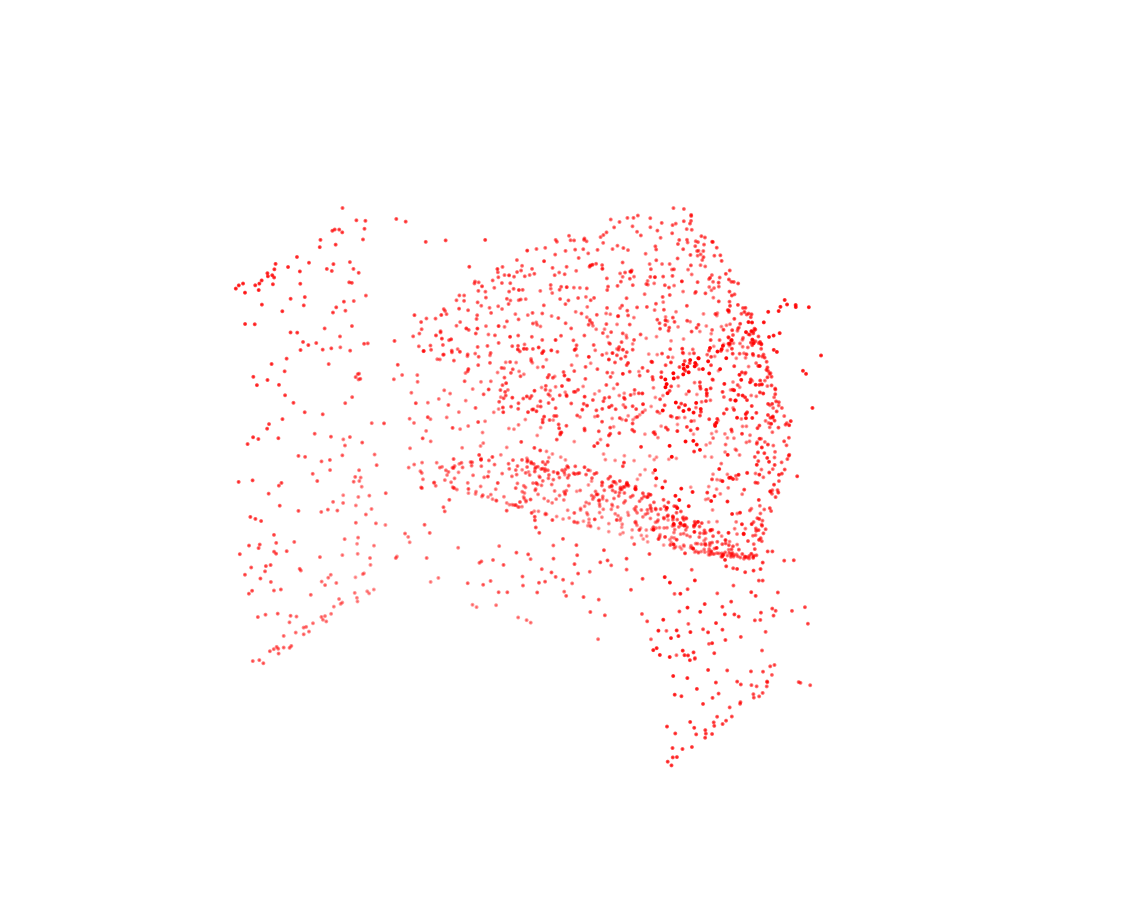

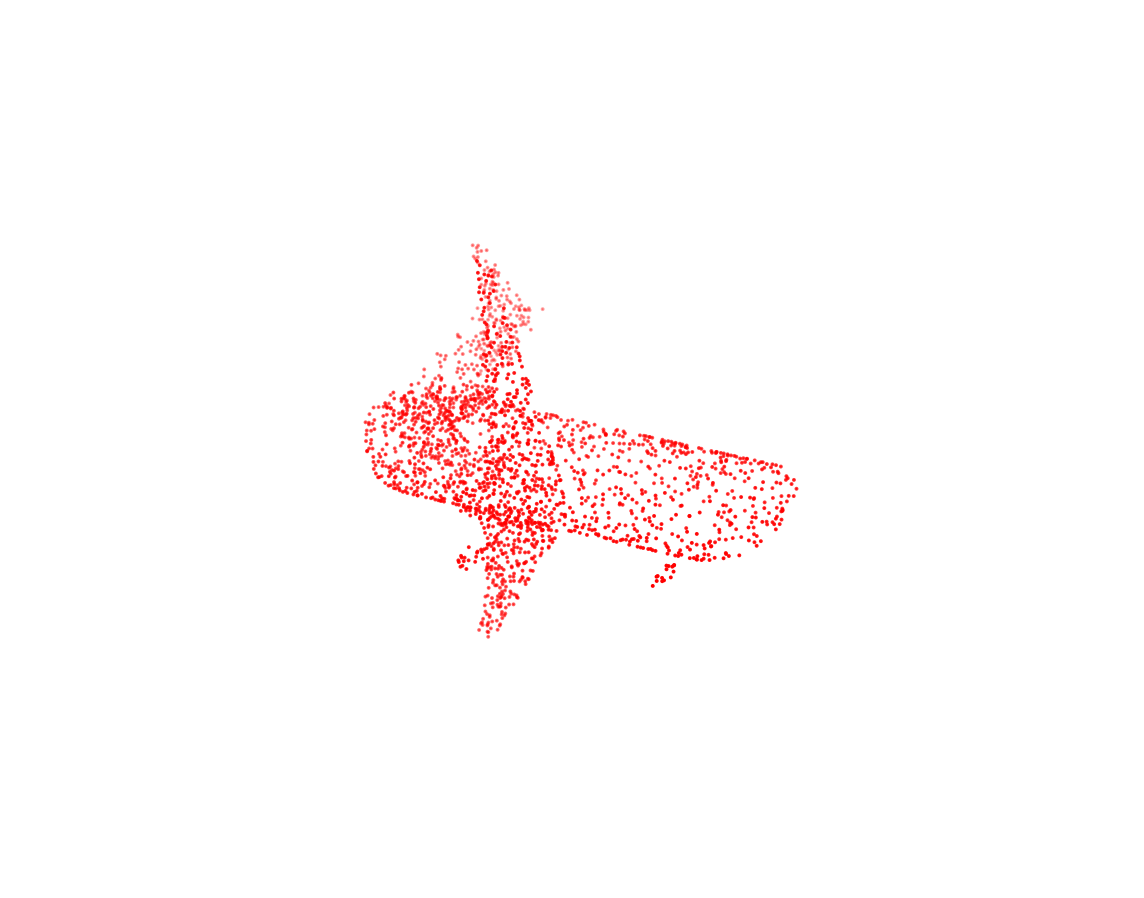

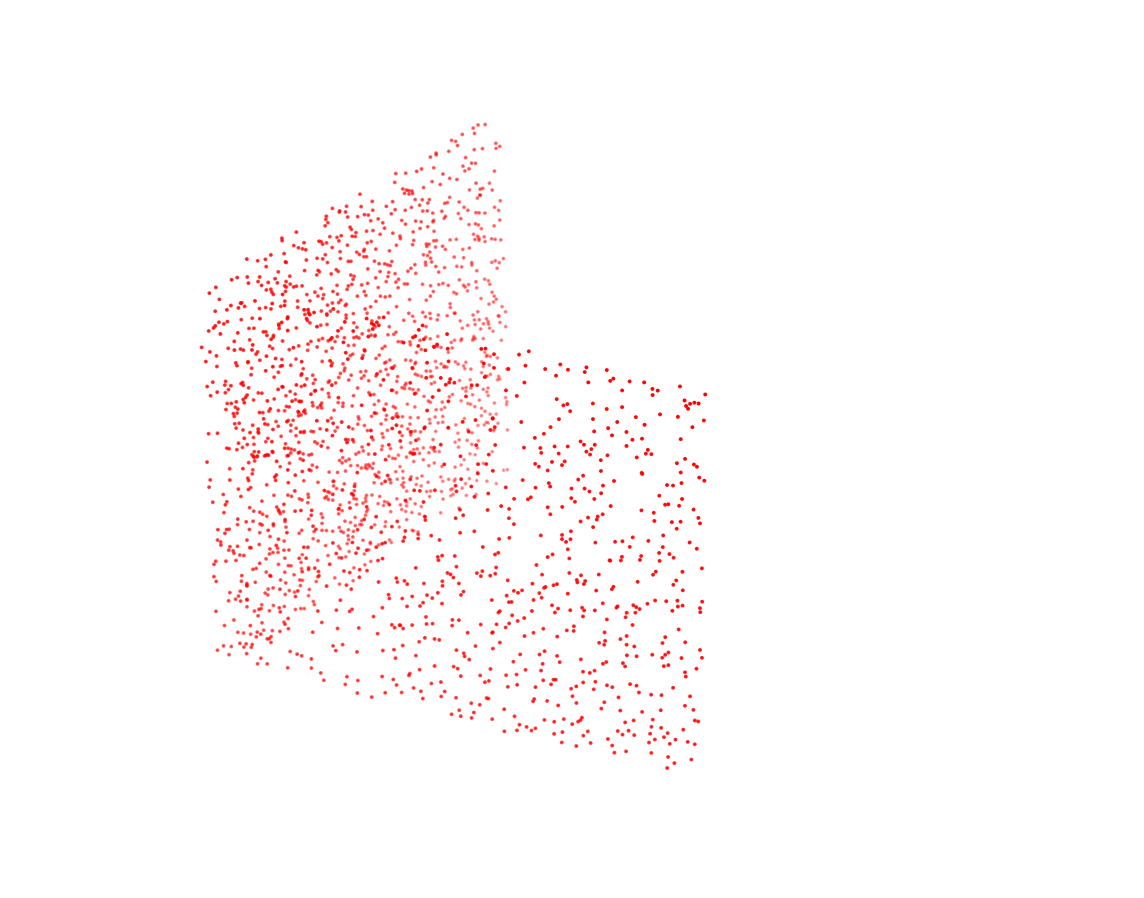

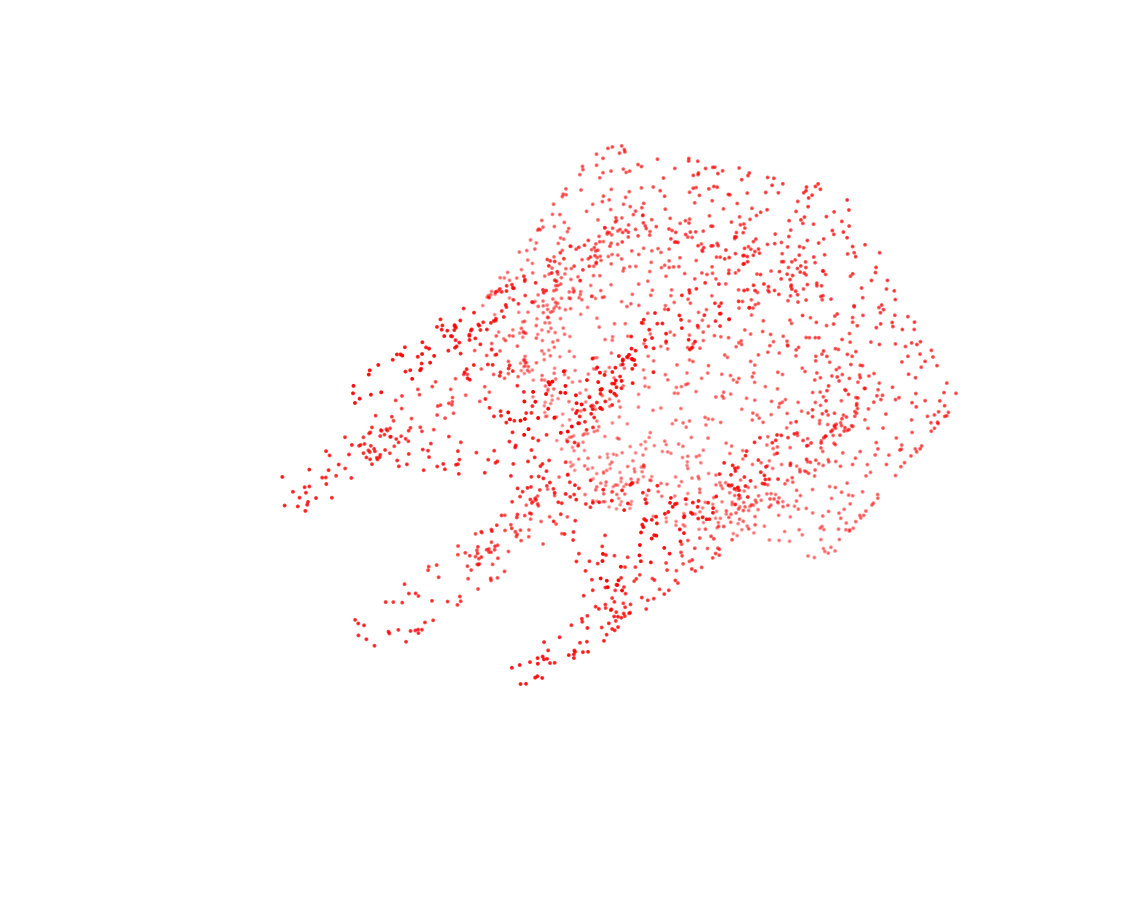

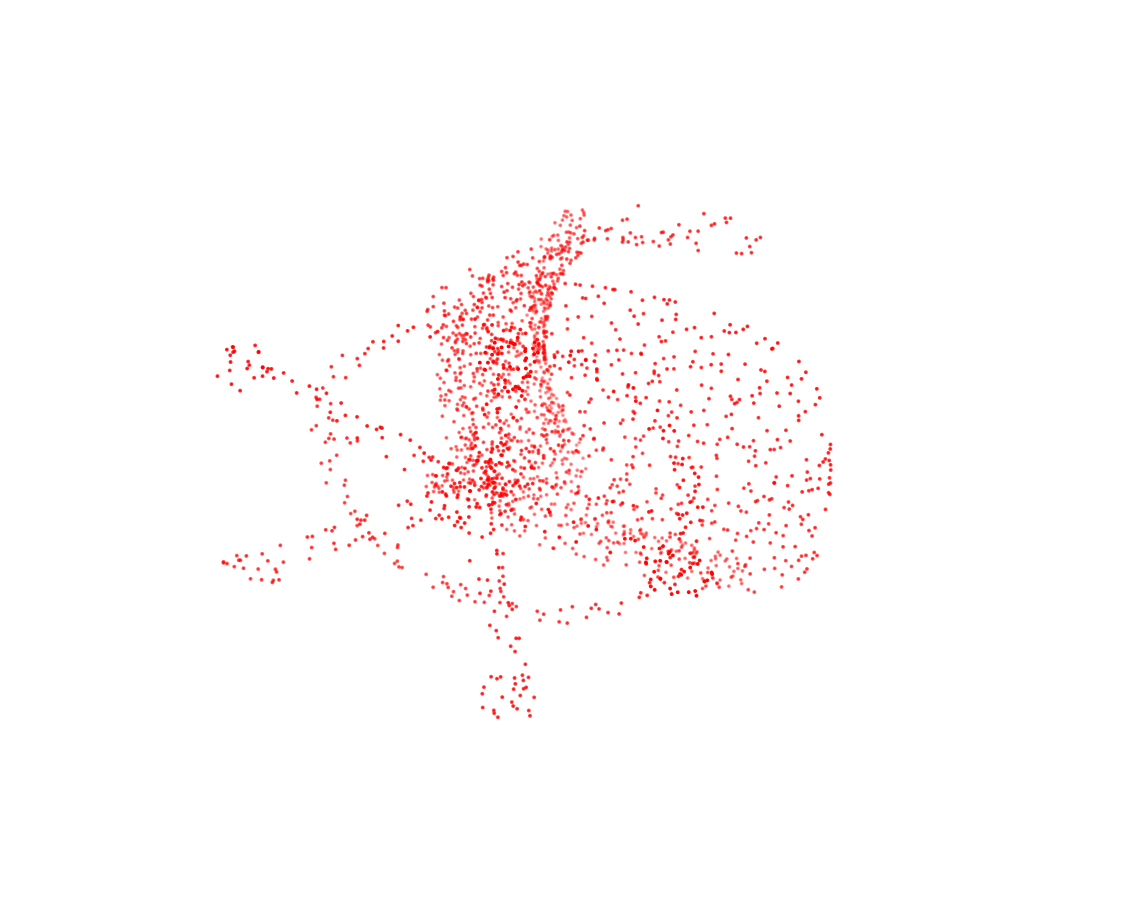

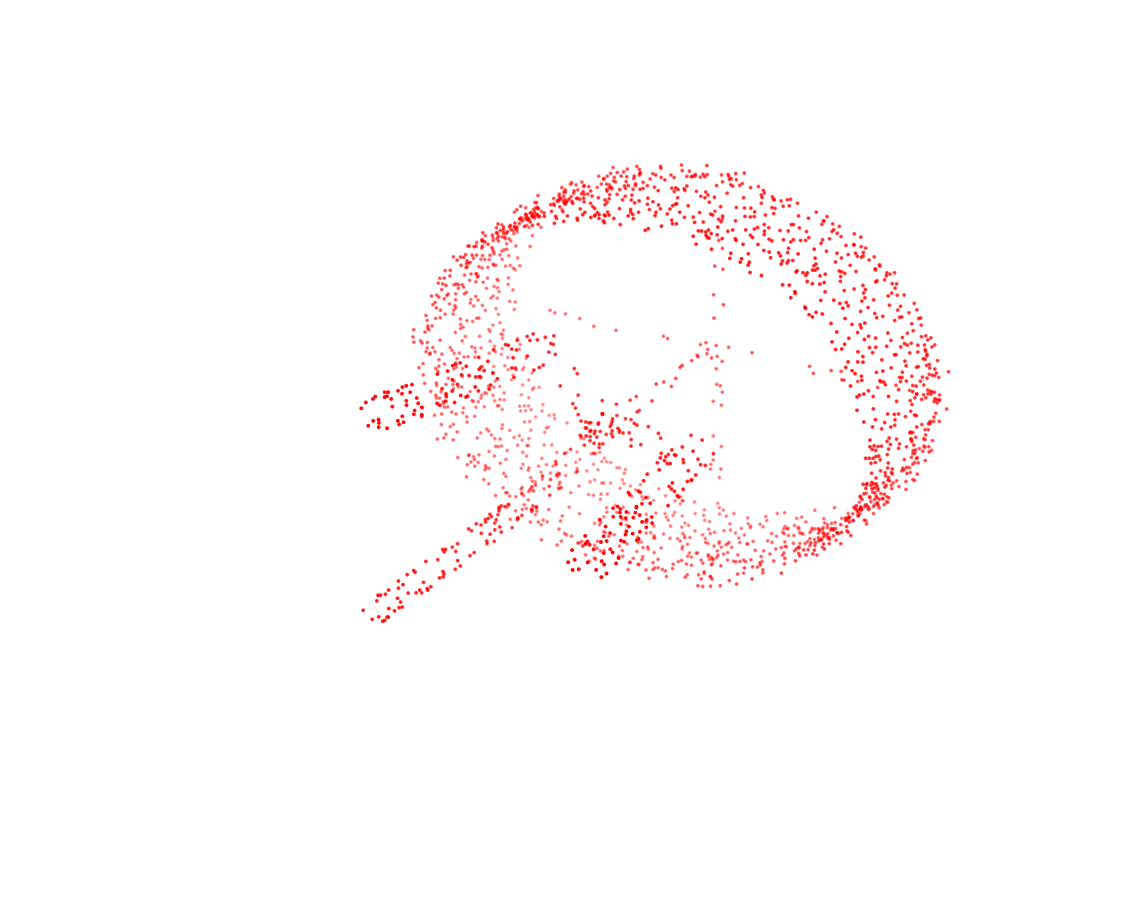

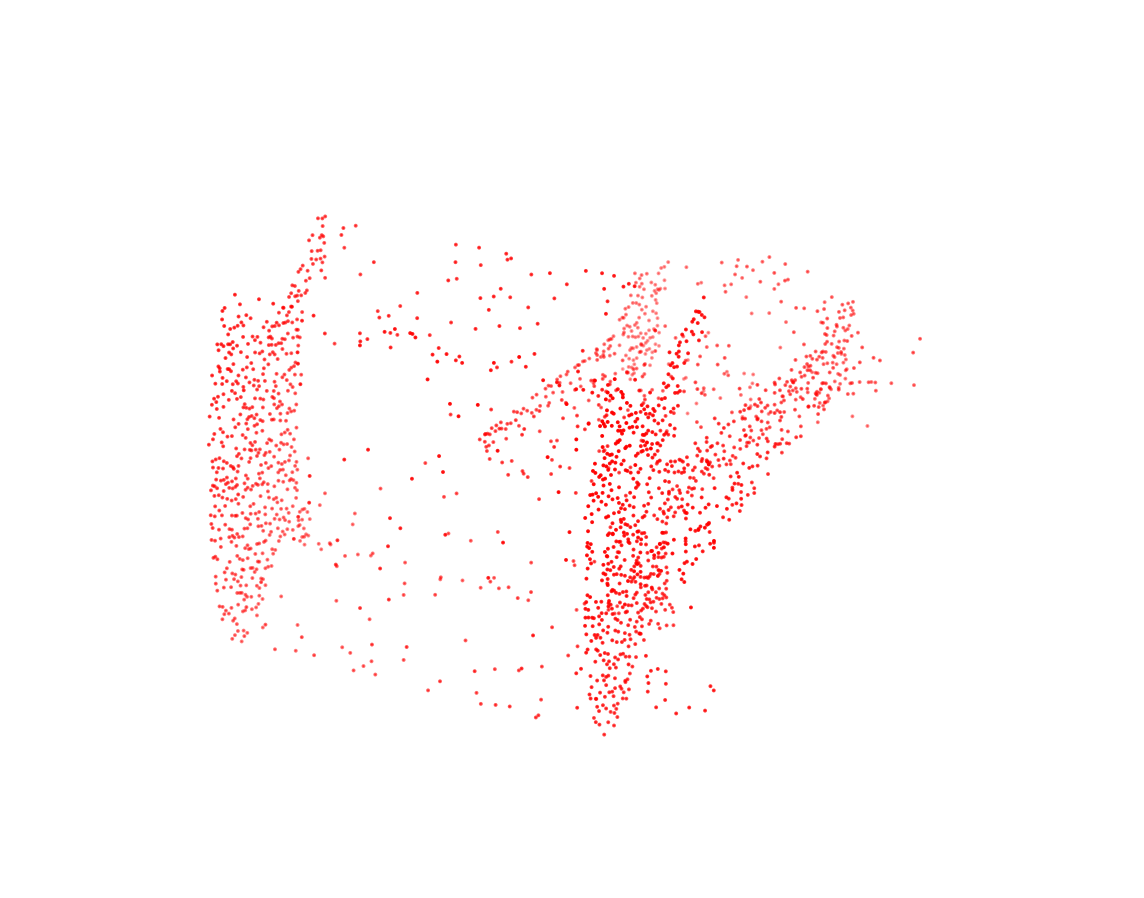

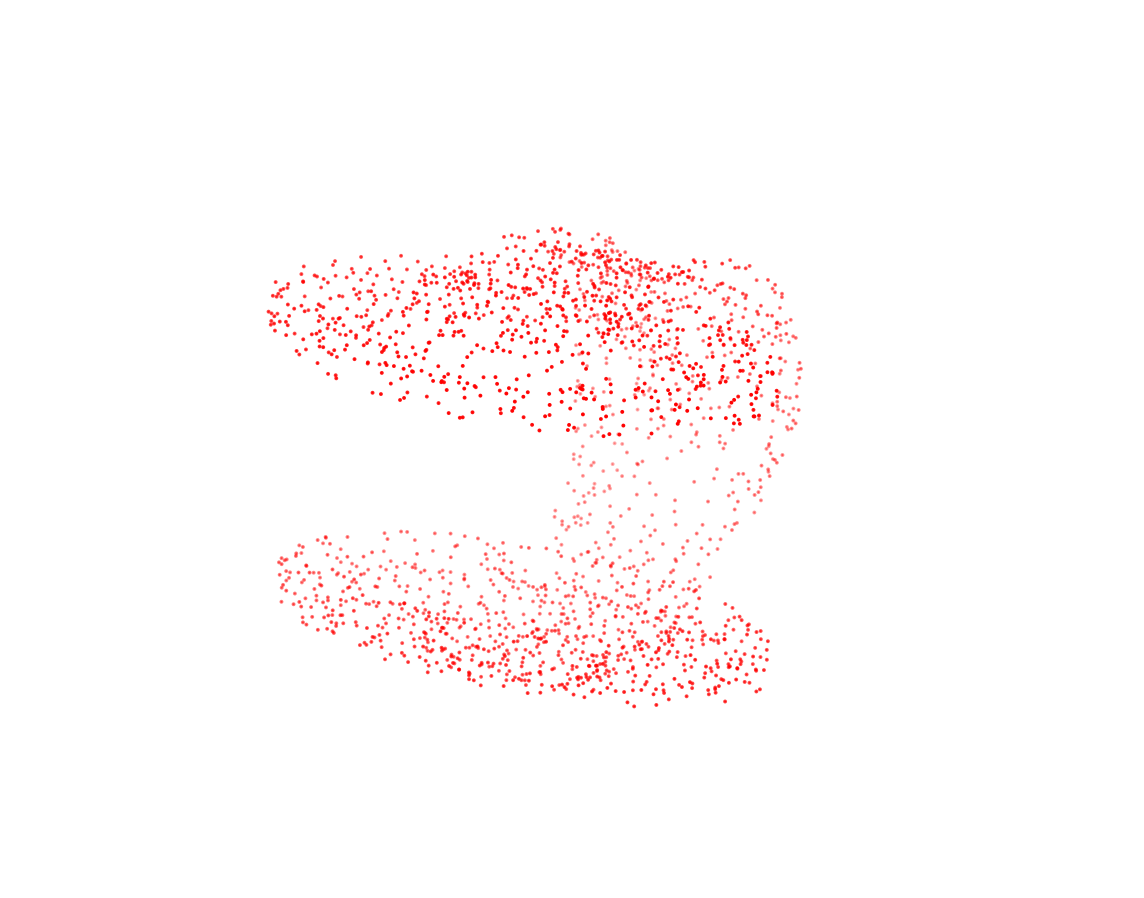

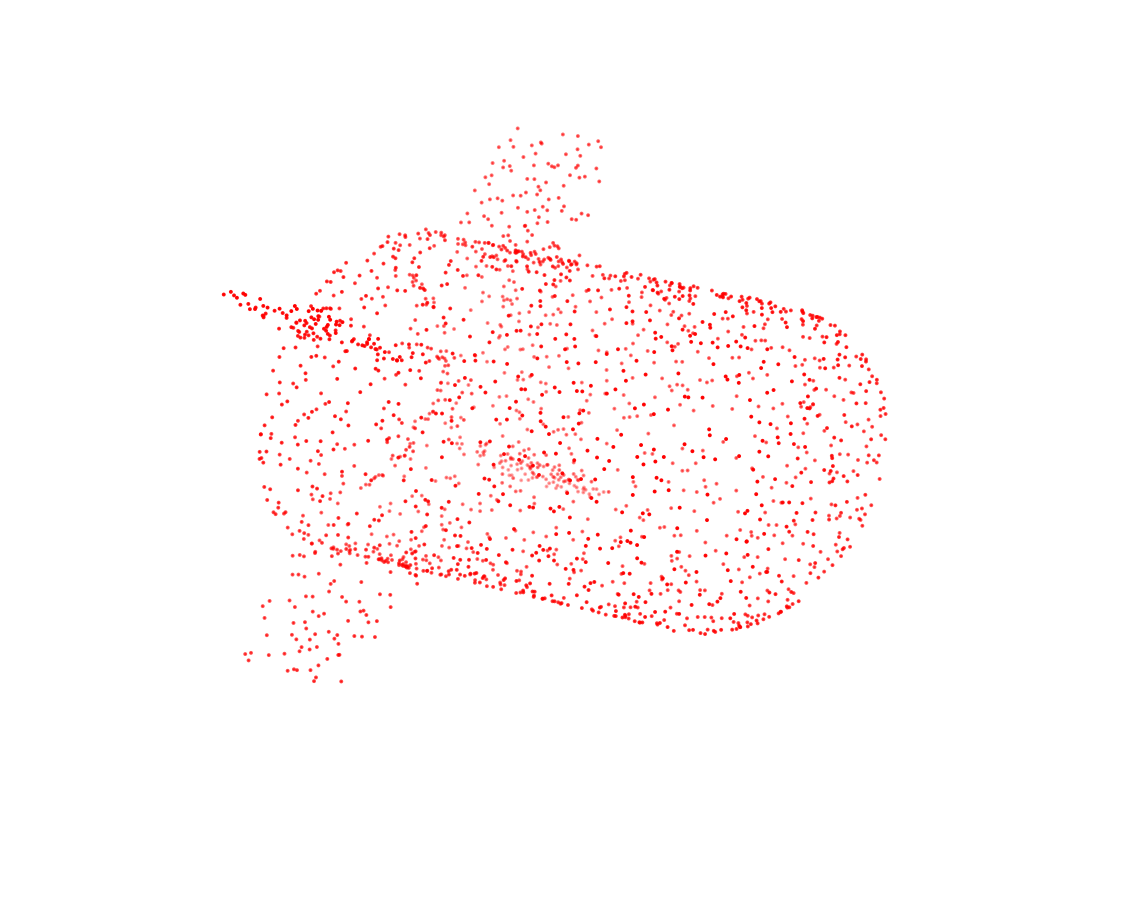

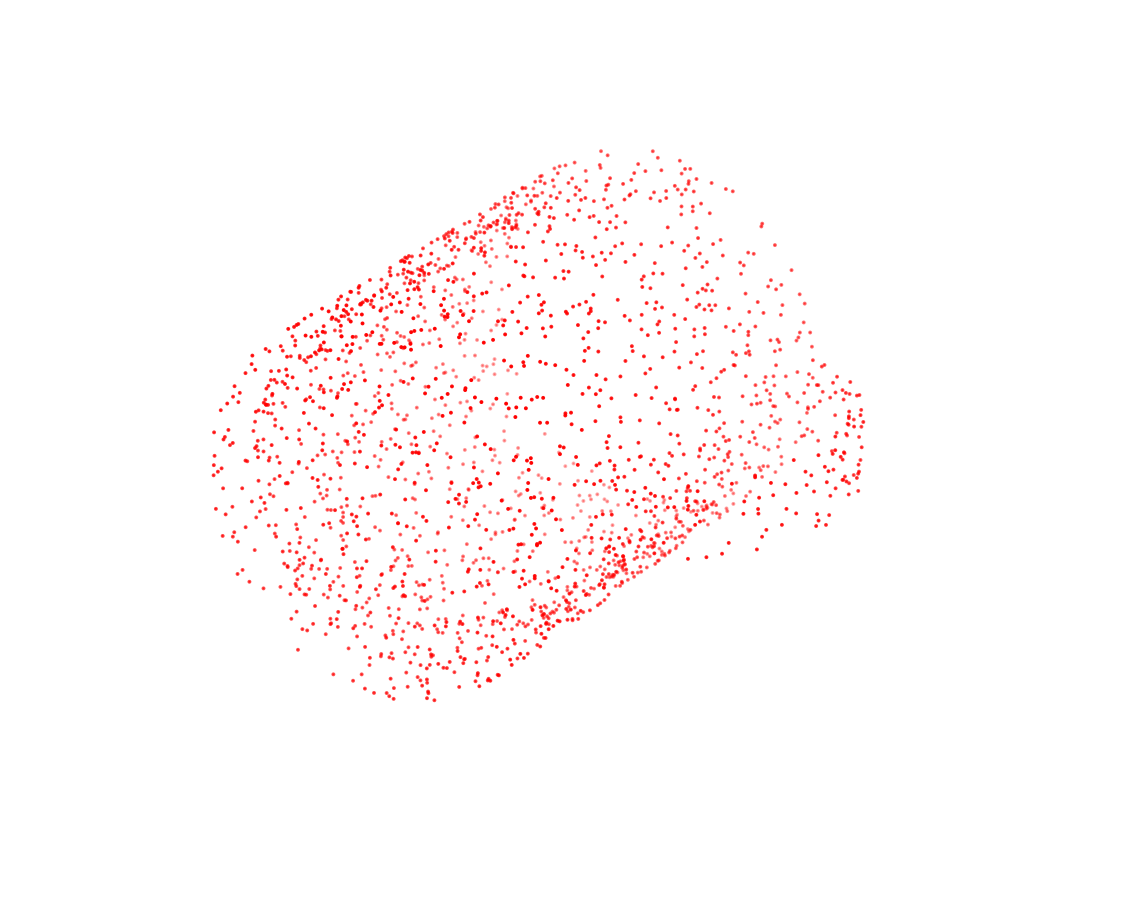

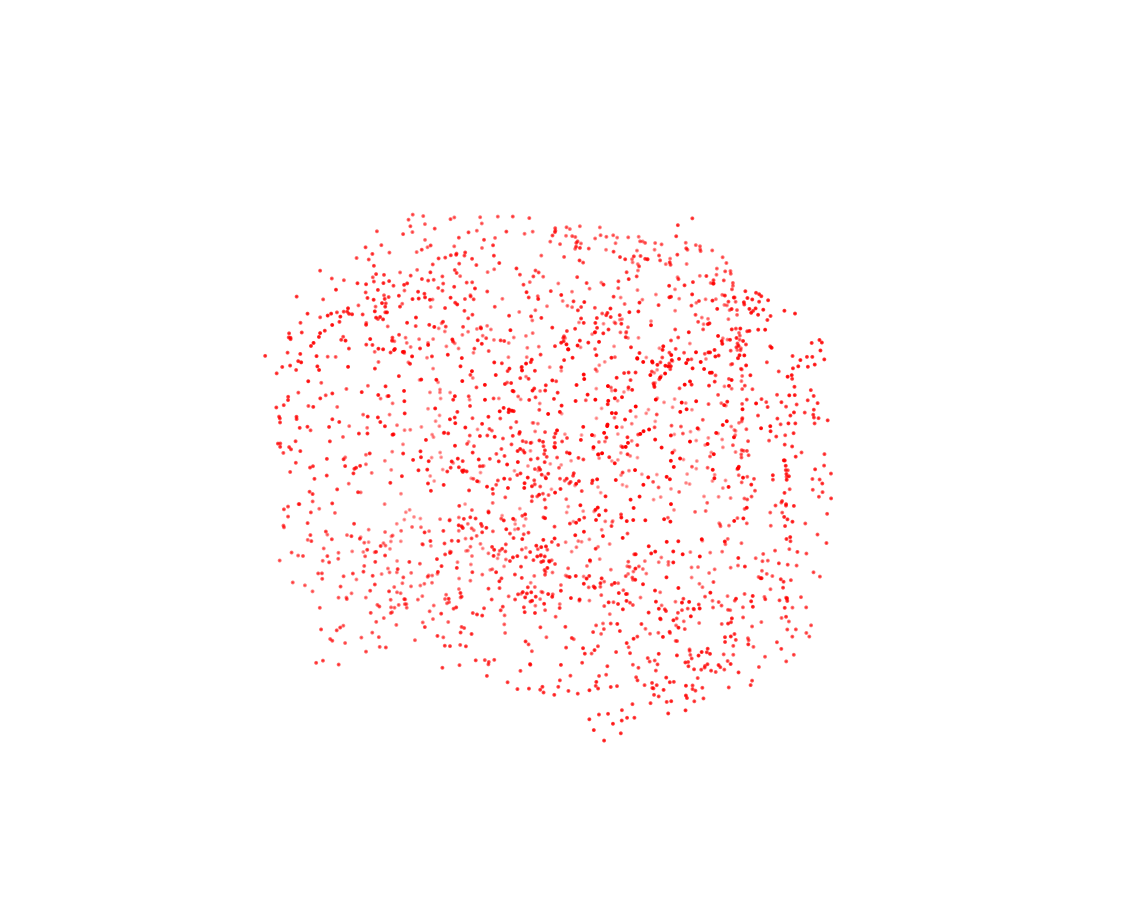

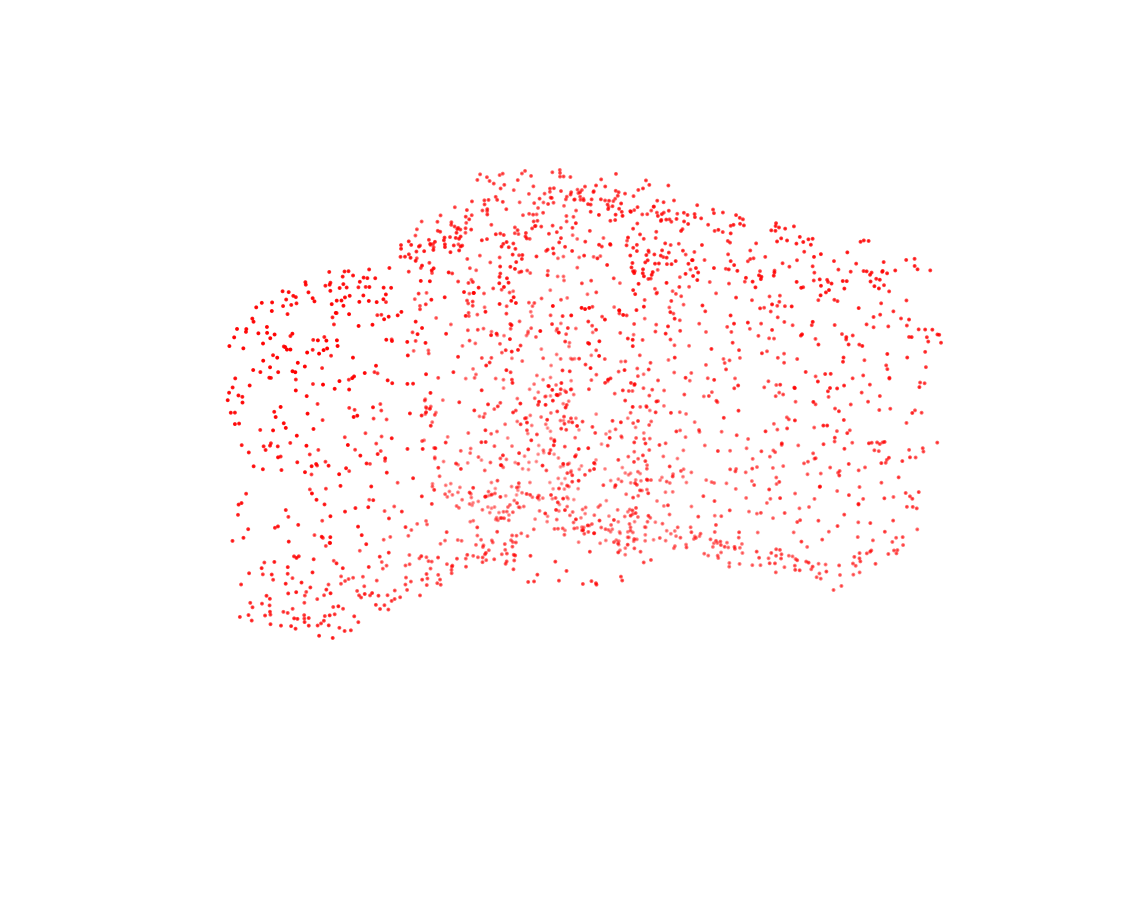

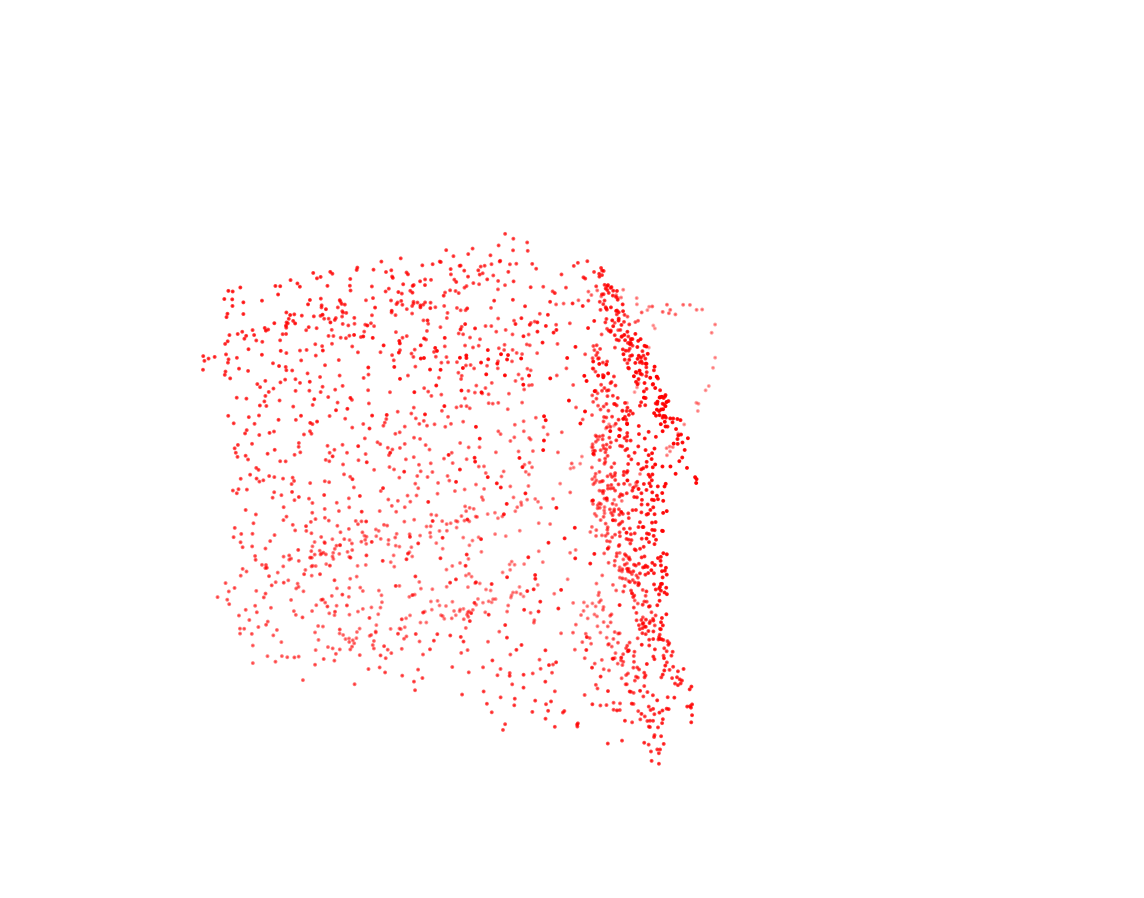

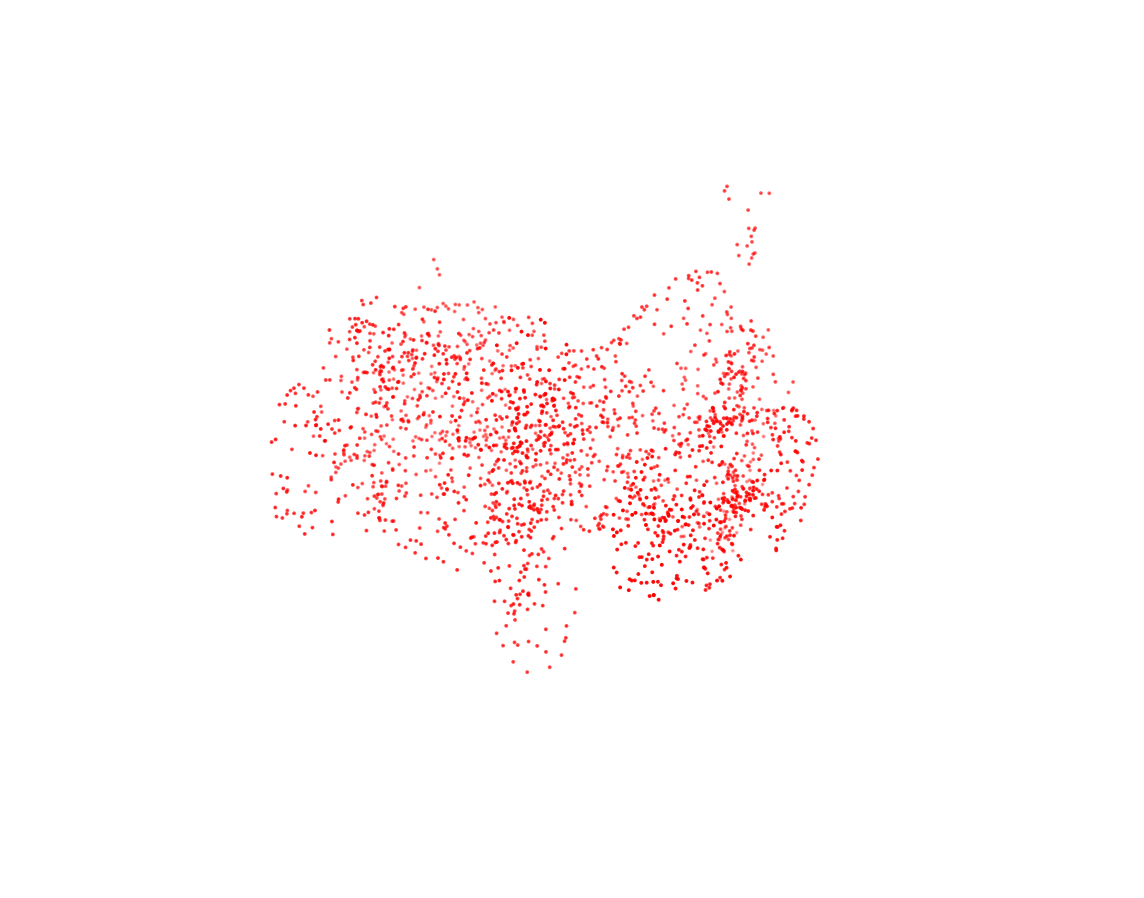

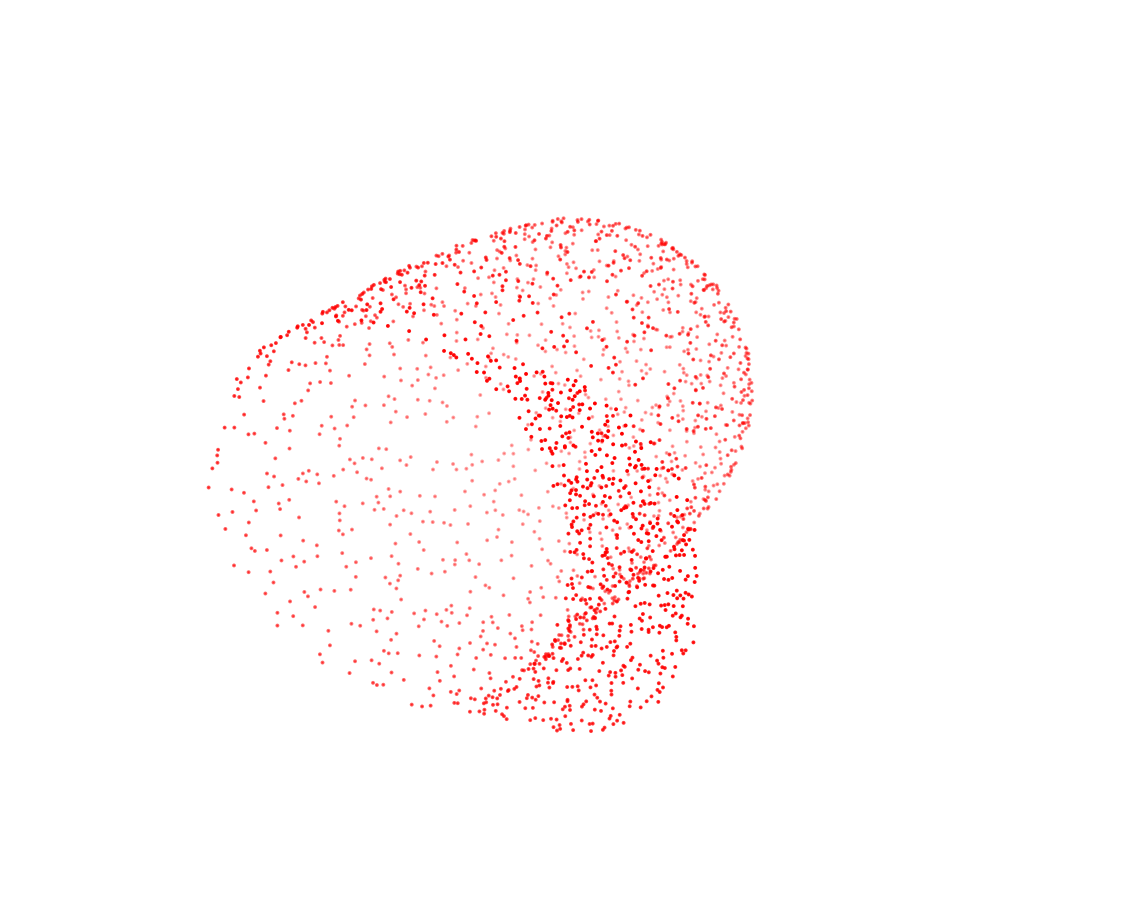

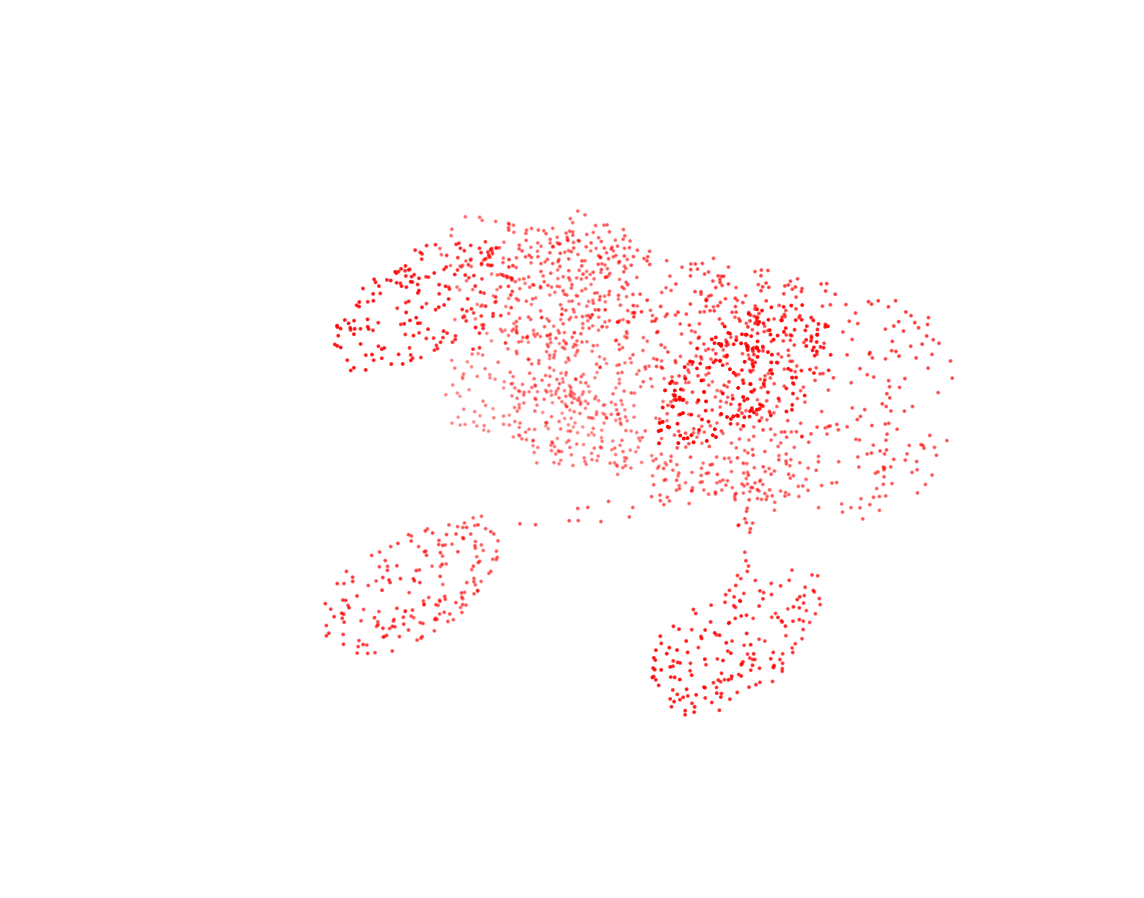

In [7]:
seen_class = set()
for i in range(len(pn_train_full)):
    if pn_train_full_labels[i][0] not in seen_class:
        visualize_npy(pn_train_full[i], save_img_fpath=None)
        seen_class.add(pn_train_full_labels[i][0])

## Single AutoDecoder Training on the Full PointNet Data

In [ ]:
adnet_HP = HyperParameter(lr=0.001, epochs=4)
adnet_DS = DirectorySetting()

fpn_autodecoder, ftrain_encoding_ds, ftest_encoding_ds, _, _ = return_decoder_train_test_encoding_ds(
    pn_train_full,
    pn_train_full_labels,
    pn_test_full,
    pn_test_full_labels,
    adnet_HP,
    adnet_DS,
    autodecoder=AutoDecoder())

## Train Single CompNet on Full PointNet Data

In [ ]:
cpnet_HP = HyperParameter(epochs=20, batch_size=16, lr=0.001)
cpnet_DS = DirectorySetting()

fcompnet1 = train_compnet(
    cpnet_HP, cpnet_DS,
    train_ds=ftrain_encoding_ds,
    save_wt_fname='full_pnet_compnet.pth')

### Single CompNet Result on Full PointNet

------------------ Evaluation Report ------------------
Total Accuracy: 0.9363928483150696
After 759 batches and 12137 test points

Metrics for the same class:
Avg loss: 0.17125665329823733
Precision: 0.9369688969556967
Recall: 0.935733706846832
F1 Score: 0.9363508945502514

Metrics for the diff class:
Avg loss: 0.1635700860103698
Precision: 0.9358183164650703
Recall: 0.9370519897833073
F1 Score: 0.9364347468093865


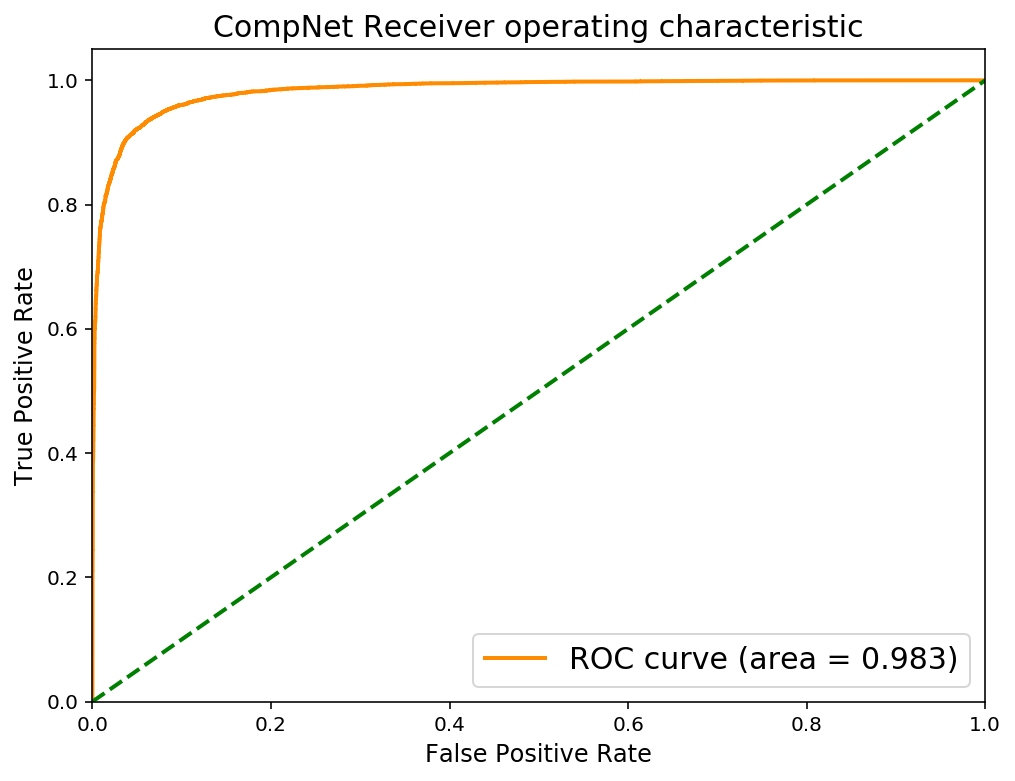

(129.98379985336214,
 124.14969528187066,
 11357.0,
 11373.0,
 780.0,
 764.0,
 759,
 12137)

In [13]:
# evaluate compnet
eval_compnet(fcompnet1, ftrain_encoding_ds)

------------------ Evaluation Report ------------------
Total Accuracy: 0.8747390396659708
After 180 batches and 2874 test points

Metrics for the same class:
Avg loss: 0.341319420405974
Precision: 0.8768369489153254
Recall: 0.871955462769659
F1 Score: 0.8743893928820655

Metrics for the diff class:
Avg loss: 0.3031444744620886
Precision: 0.8726643598615917
Recall: 0.8775226165622826
F1 Score: 0.875086745315753


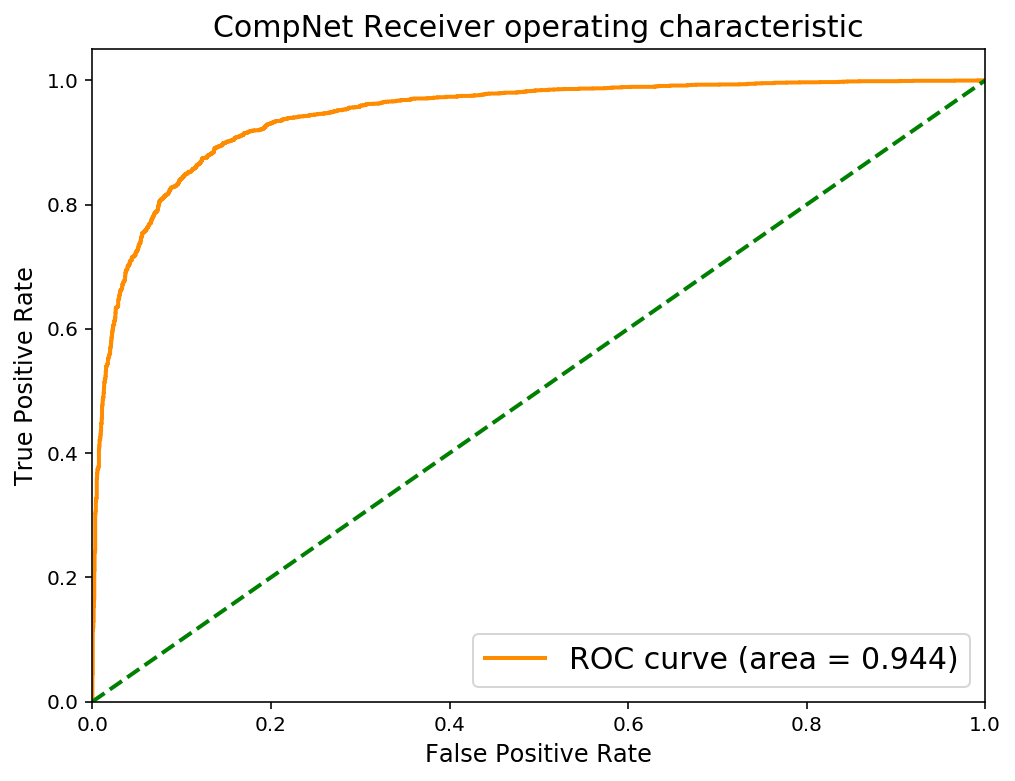

(61.43749567307532, 54.56600540317595, 2506.0, 2522.0, 368.0, 352.0, 180, 2874)

In [14]:
# evaluate compnet
eval_compnet(fcompnet1, ftest_encoding_ds)

### Train the Ensemble CompNets on Full PointNet

In [ ]:
ensemble_HP = HyperParameter(lr=0.001, batch_size=16)

# Train with the ensemble net
fensemble1 = train_compnet(ensemble_HP, DS,
                           train_ds=ftrain_encoding_ds,
                           compnet=EnsembleCompNet(),
                           save_wt_fname='full_pnet_ensemble1.pth')

### Ensemble CompNet results on Full PointNet

------------------ Evaluation Report ------------------
Total Accuracy: 0.9892477547993738
After 759 batches and 12137 test points

Metrics for the same class:
Avg loss: 0.07763537262567614
Precision: 0.9928618857901726
Recall: 0.9855812803823021
F1 Score: 0.9892081868927021

Metrics for the diff class:
Avg loss: 0.12745359100214892
Precision: 0.9856862424341567
Recall: 0.9929142292164456
F1 Score: 0.9892870336165496


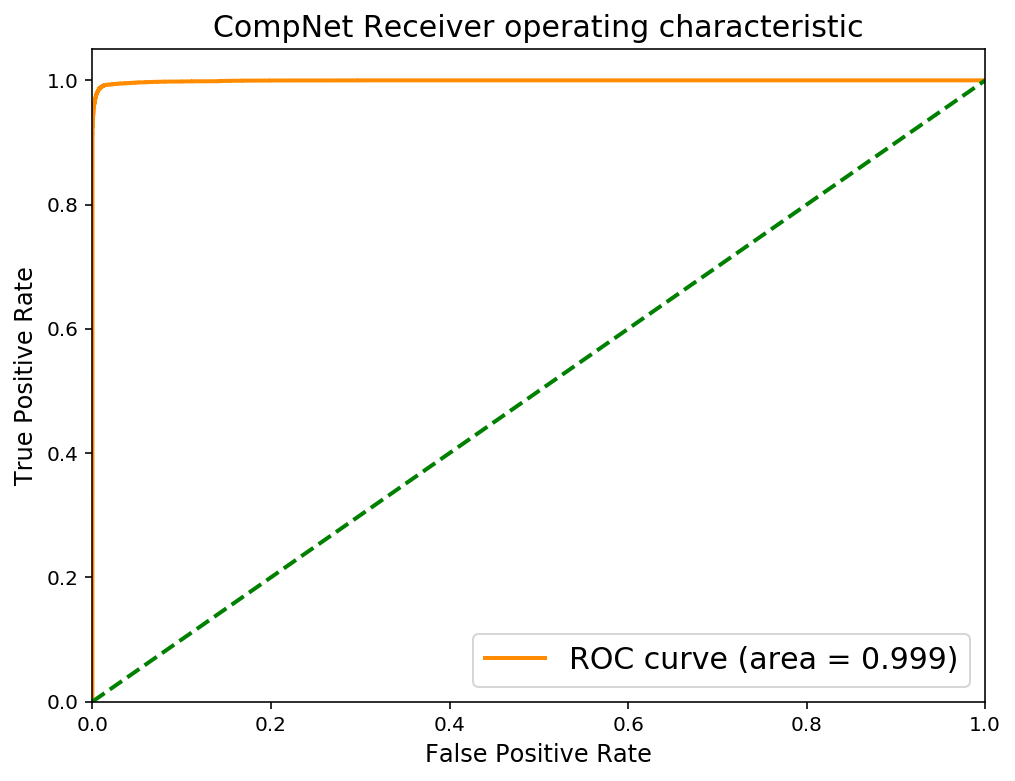

(58.925247822888196,
 96.73727557063103,
 11962.0,
 12051.0,
 175.0,
 86.0,
 759,
 12137)

In [16]:
eval_compnet(fensemble1, ftrain_encoding_ds)

------------------ Evaluation Report ------------------
Total Accuracy: 0.9810368823938761
After 180 batches and 2874 test points

Metrics for the same class:
Avg loss: 0.10828197359159175
Precision: 0.988343341575415
Recall: 0.9735560194850382
F1 Score: 0.9808939526730936

Metrics for the diff class:
Avg loss: 0.1435527882642216
Precision: 0.9739458347617416
Recall: 0.988517745302714
F1 Score: 0.9811776895182178


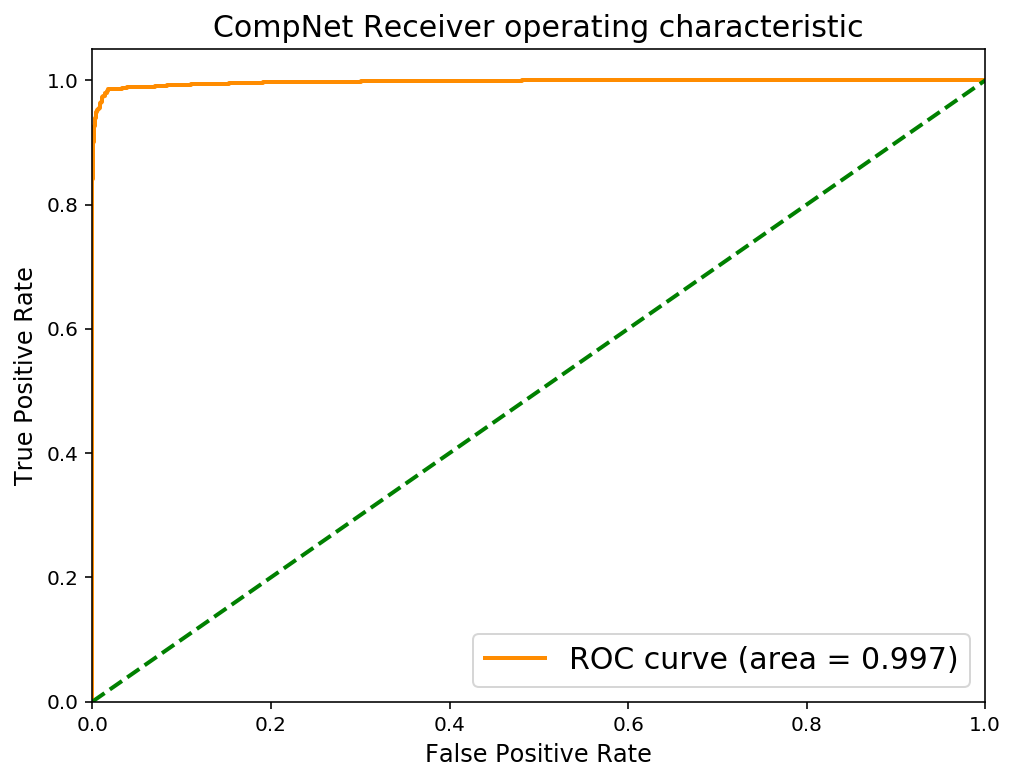

(19.490755246486515, 25.83950188755989, 2798.0, 2841.0, 76.0, 33.0, 180, 2874)

In [17]:
eval_compnet(fensemble1, ftest_encoding_ds)

# Testing our Model with PointNet Data

## Load PointNet7 Data

In [8]:
pn_train_data   = np.load("./data/PointNetData/train/pntcloud_7.npy")
pn_train_labels = np.load("./data/PointNetData/train/label_7.npy")
pn_test_data    = np.load("./data/PointNetData/test/pntcloud_7.npy")
pn_test_labels  = np.load("./data/PointNetData/test/label_7.npy")

pn_train_data.shape, pn_train_labels.shape, pn_test_data.shape, pn_test_labels.shape

((10817, 2048, 3), (10817, 1), (2507, 2048, 3), (2507, 1))

### Count the number of samples for different classes

In [9]:
print("Train data count")
count_unique_labels(pn_train_labels)
print("Test data count")
count_unique_labels(pn_test_labels)

Train data count
(10817, 1)
0 1958
2 39
3 659
4 2658
6 550
8 1118
15 3835
Test data count
(2507, 1)
0 341
2 11
3 158
4 704
6 159
8 286
15 848


## Looking at images in our PointNet data

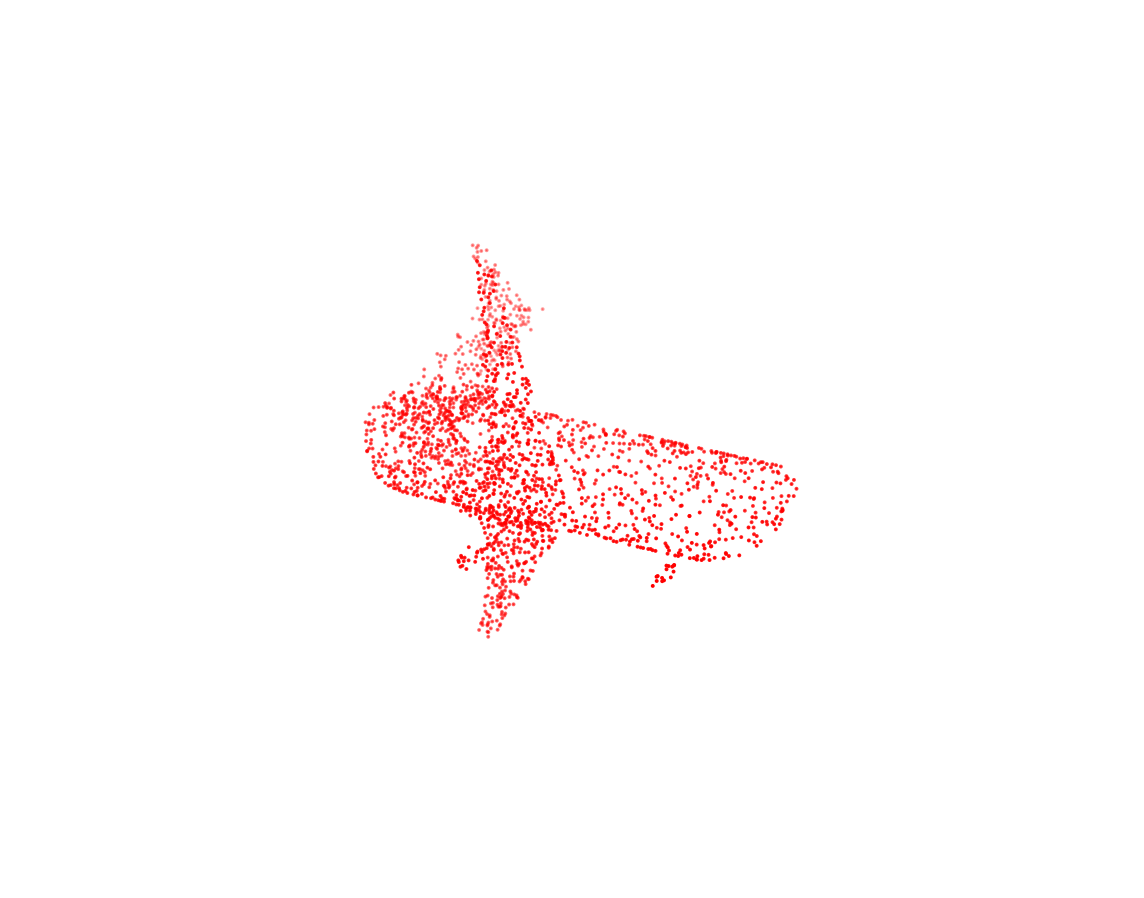

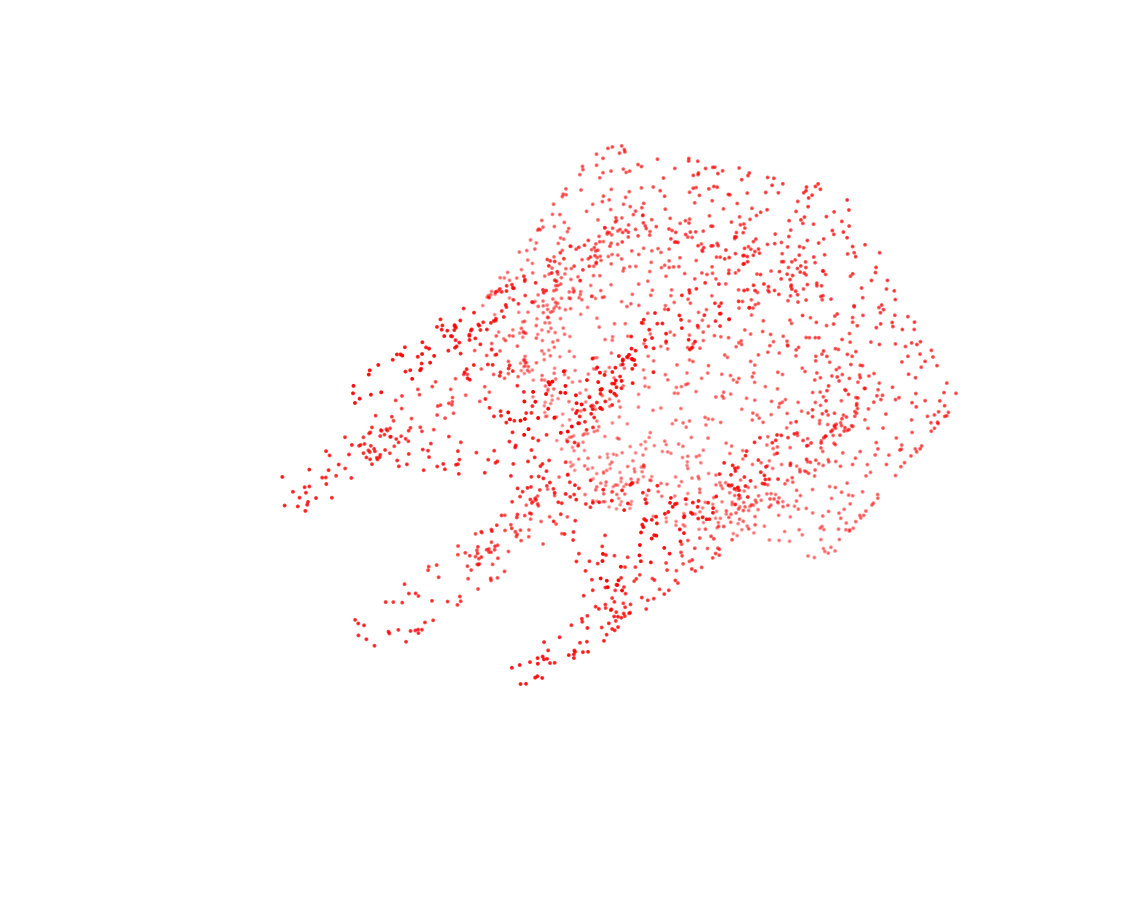

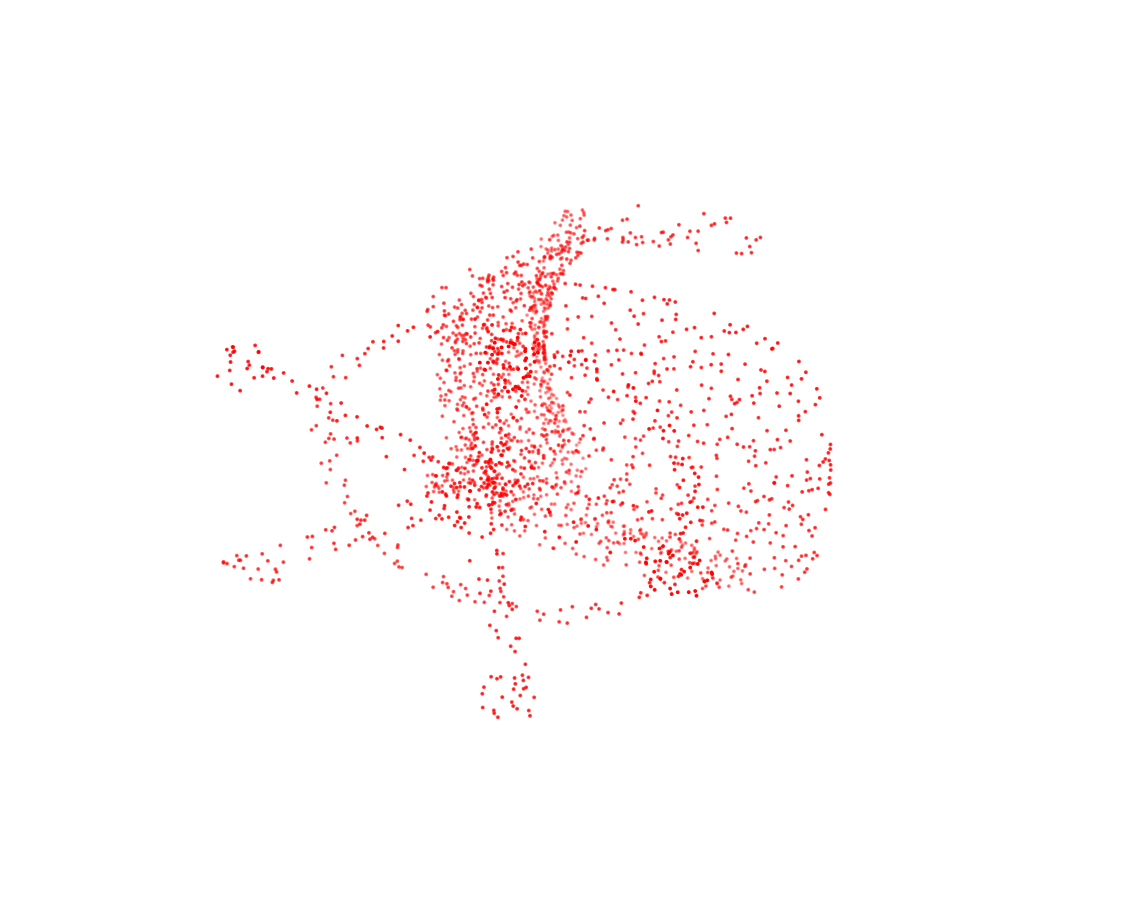

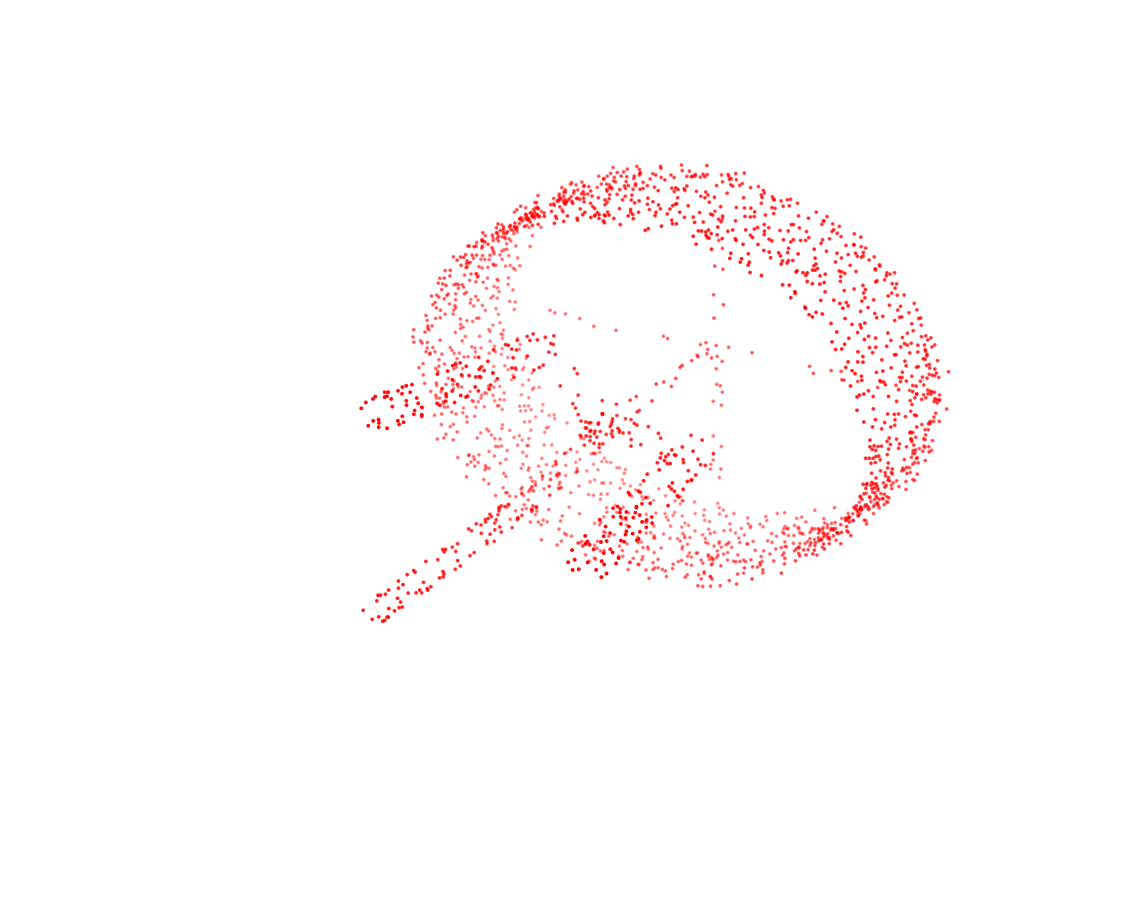

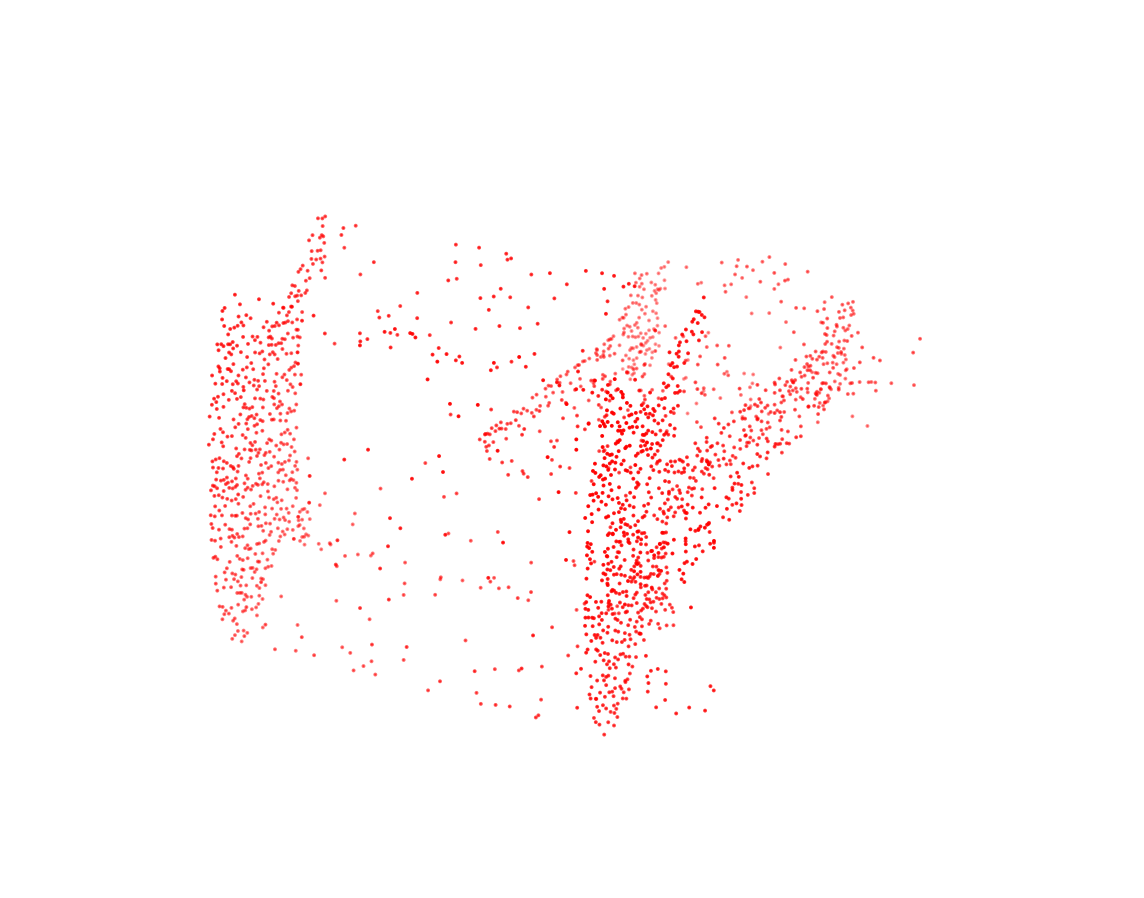

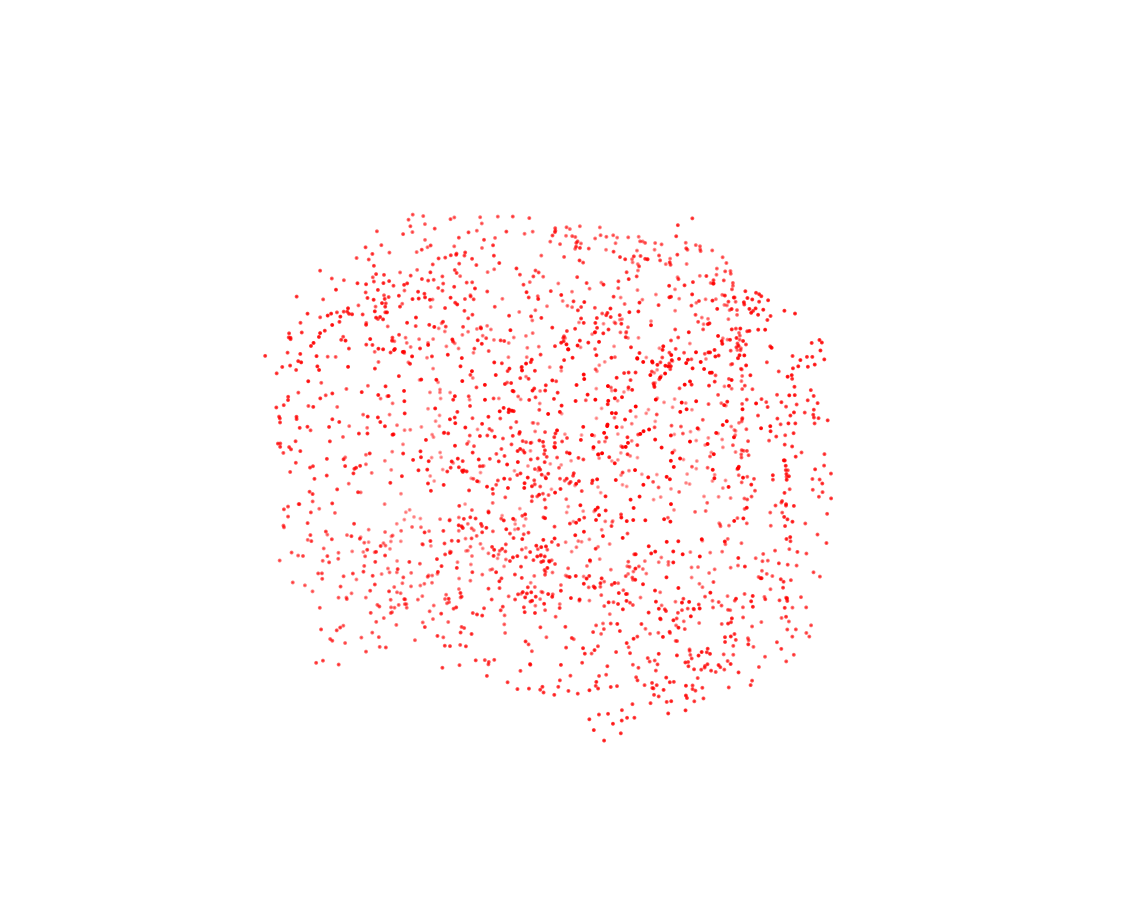

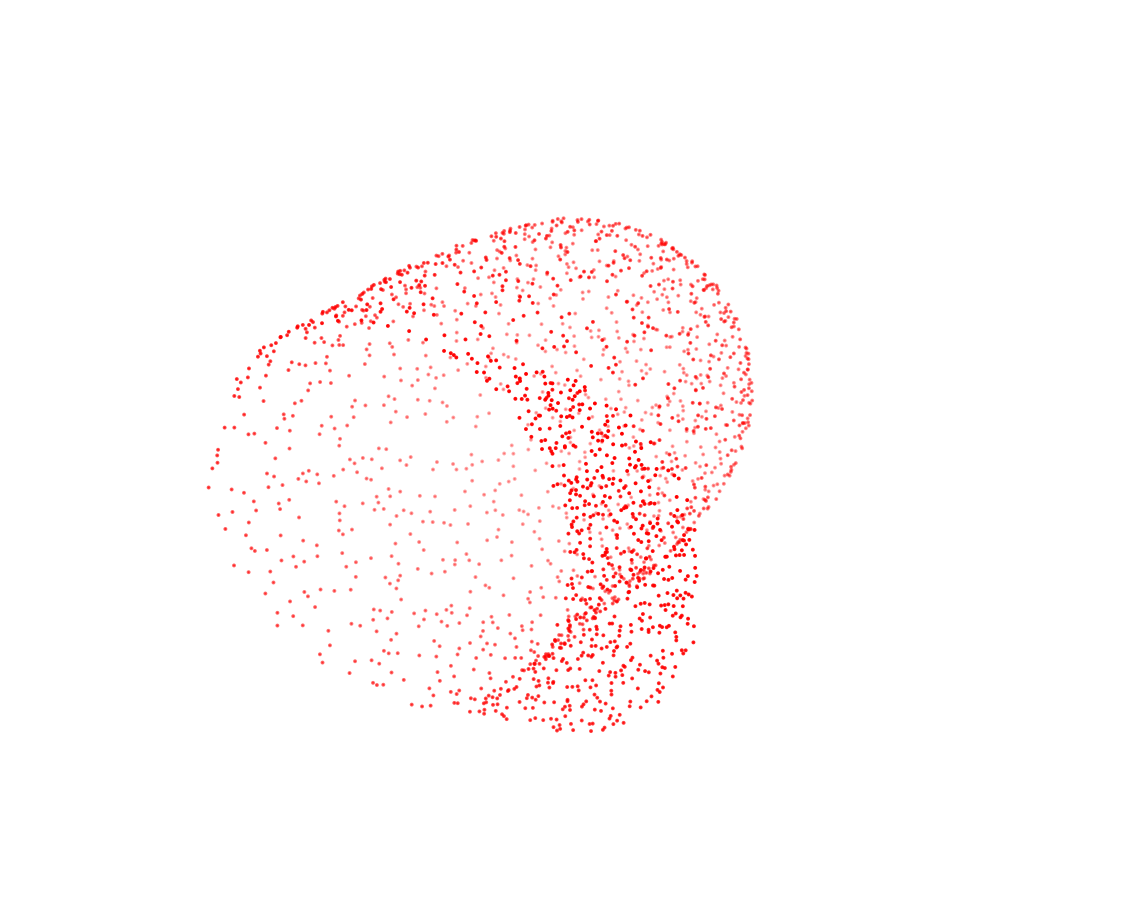

In [10]:
seen_class = set()
for i in range(len(pn_train_data)):
    if pn_train_labels[i][0] not in seen_class:
        visualize_npy(pn_train_data[i], save_img_fpath=None)
        seen_class.add(pn_train_labels[i][0])

________

# Training and Testing different models on the PointNet 7 Data

## Train AutoDecoder

**Note:** Training takes a while

In [7]:
load_saved_weight = False

if load_saved_weight:
    try:
        pn_load_adnet = AutoDecoder(HP.encoding_size, HP.num_point_cloud)
        pn_load_adnet.load_state_dict(torch.load(DS.AUTODECODER_TRAINED_WEIGHT_DIR+'/pnet_decoder.pth'))
        print('Loaded decoder saved weights from', DS.AUTODECODER_TRAINED_WEIGHT_DIR+'/pnet_decoder.pth')
    except (RuntimeError,FileNotFoundError) as e:
        print(e)
        pn_load_adnet = AutoDecoder(HP.encoding_size, HP.num_point_cloud)
else:
    print("Training a new Decoder")
    pn_load_adnet = AutoDecoder(HP.encoding_size, HP.num_point_cloud)

Training a new Decoder


In [ ]:
adnet_HP = HyperParameter(lr=0.001, epochs=4)
adnet_DS = DirectorySetting()

pn_autodecoder, train_encoding_ds, test_encoding_ds, _, _ = return_decoder_train_test_encoding_ds(
    pn_train_data,
    pn_train_labels,
    pn_test_data,
    pn_test_labels,
    adnet_HP,
    adnet_DS,
    autodecoder=pn_load_adnet)

In [9]:
""" Get memory usage of active variables """
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('pn_train_data', 265838720),
 ('pn_test_data', 61612160),
 ('pn_train_labels', 10929),
 ('pn_test_labels', 2619),
 ('DataLoader', 1464),
 ('AutoDecoder', 1184),
 ('CompNet', 1184),
 ('EnsembleCompNet', 1184),
 ('HyperParameter', 1184),
 ('Dataset', 1056),
 ('DirectorySetting', 1056),
 ('EncodingDS', 1056),
 ('EnsembleAutoDecoder', 1056),
 ('GaussianNB', 1056),
 ('LogisticRegression', 1056),
 ('PointDriftDS', 1056),
 ('PointNetDS', 1056),
 ('RBFSampler', 1056),
 ('RandomForestClassifier', 1056),
 ('SGDClassifier', 1056),
 ('Variable', 1056),
 ('seen_class', 736),
 ('auc', 136),
 ('chamfer_loss', 136),
 ('eval_compnet', 136),
 ('eval_decision_trees', 136),
 ('eval_decoder', 136),
 ('eval_gaussian_naive_bayes', 136),
 ('eval_log_regr', 136),
 ('eval_rand_forest', 136),
 ('eval_svm', 136),
 ('find_encoding', 136),
 ('get_X_y_from_npy', 136),
 ('get_train_test_split_from_npy', 136),
 ('hinge_loss', 136),
 ('log_loss', 136),
 ('print_model_metrics', 136),
 ('return_decoder_train_test_encod

## Train a single CompNet on the PointNet7 Data

In [ ]:
cpnet_HP = HyperParameter(epochs=20, batch_size=16, lr=0.001)
cpnet_DS = DirectorySetting()

compnet1 = train_compnet(cpnet_HP, cpnet_DS, 
                         train_ds=train_encoding_ds,
                         save_wt_fname='pnet_compnet.pth')

## Evaluate the Single CompNet

------------------ Evaluation Report ------------------
Total Accuracy: 0.9328372007025978
After 677 batches and 10817 test points

Metrics for the same class:
Avg loss: 0.17864064152991851
Precision: 0.933839881393625
Recall: 0.9316816122769714
F1 Score: 0.9327594983571661

Metrics for the diff class:
Avg loss: 0.17688396792897357
Precision: 0.9318391440693599
Recall: 0.9339927891282241
F1 Score: 0.9329147236714529


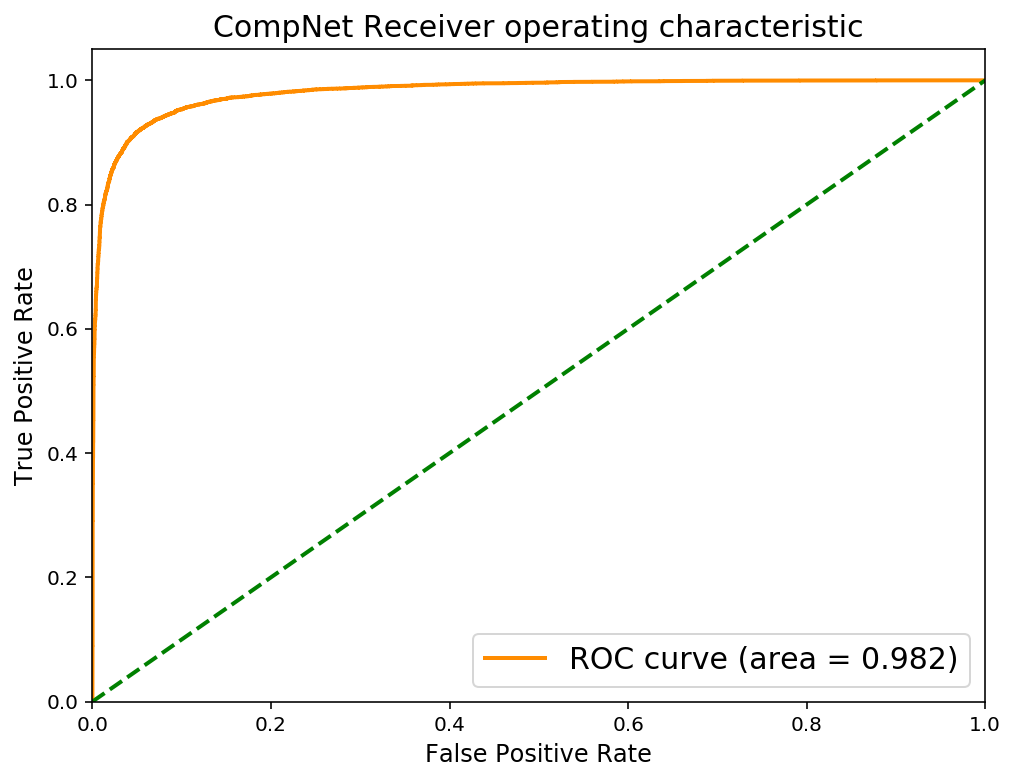

(120.93971431575483,
 119.75044628791511,
 10078.0,
 10103.0,
 739.0,
 714.0,
 677,
 10817)

In [11]:
eval_compnet(compnet1, train_encoding_ds)

------------------ Evaluation Report ------------------
Total Accuracy: 0.8763462305544475
After 157 batches and 2507 test points

Metrics for the same class:
Avg loss: 0.34347085498131
Precision: 0.879372738238842
Recall: 0.8723573992820104
F1 Score: 0.8758510212254706

Metrics for the diff class:
Avg loss: 0.3027985140586355
Precision: 0.8733676296003166
Recall: 0.8803350618268847
F1 Score: 0.8768375049662296


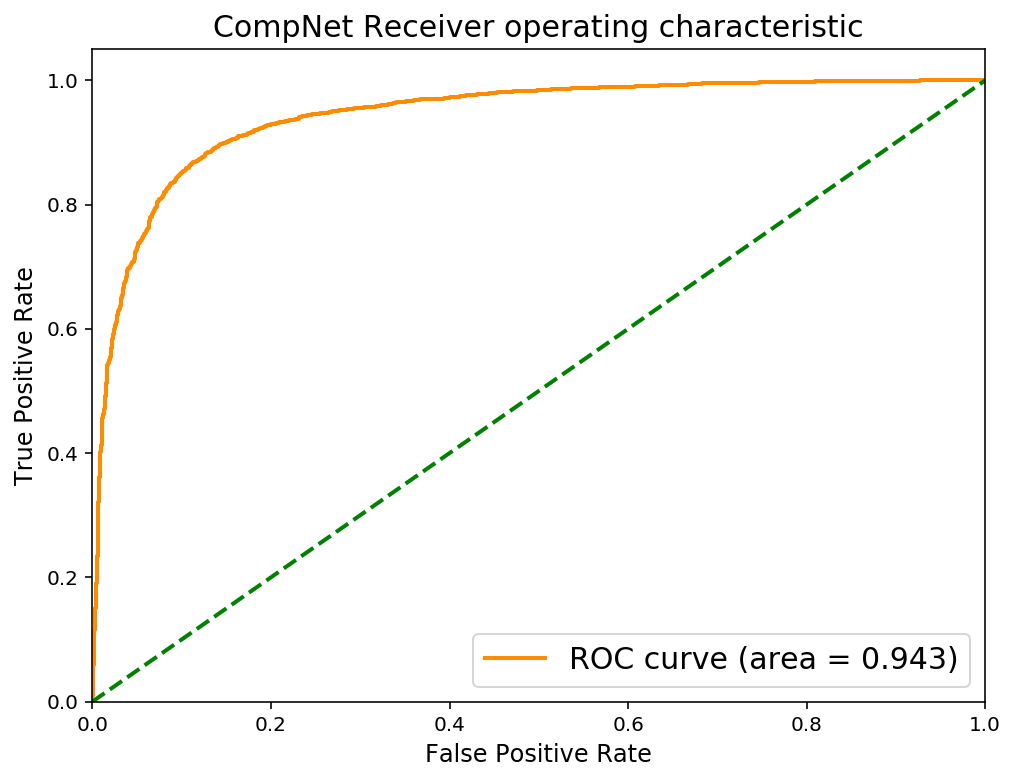

(53.92492423206568, 47.53936670720577, 2187.0, 2207.0, 320.0, 300.0, 157, 2507)

In [12]:
eval_compnet(compnet1, test_encoding_ds)

## Training an Ensemble of randomly initialized CompNets on PointNet7 Data

The individual ensemble nets are the same CompNets but are initialized with differing initializations to the classifiers independent as possible

In [ ]:
ensemble_HP = HyperParameter(lr=0.001, batch_size=16)

ensemble1 = train_compnet(ensemble_HP, DS, 
                          train_ds=train_encoding_ds, 
                          save_wt_fname='pnet_ensemble1.pth',
                          compnet=EnsembleCompNet())

## Evaluate the Ensemble CompNets

------------------ Evaluation Report ------------------
Total Accuracy: 0.9830359619118055
After 677 batches and 10817 test points

Metrics for the same class:
Avg loss: 0.05247043043428666
Precision: 0.9746547965116279
Recall: 0.9918646574835907
F1 Score: 0.983184421534937

Metrics for the diff class:
Avg loss: 0.19434630289739838
Precision: 0.9917184265010351
Recall: 0.9742072663400203
F1 Score: 0.9828848575292635


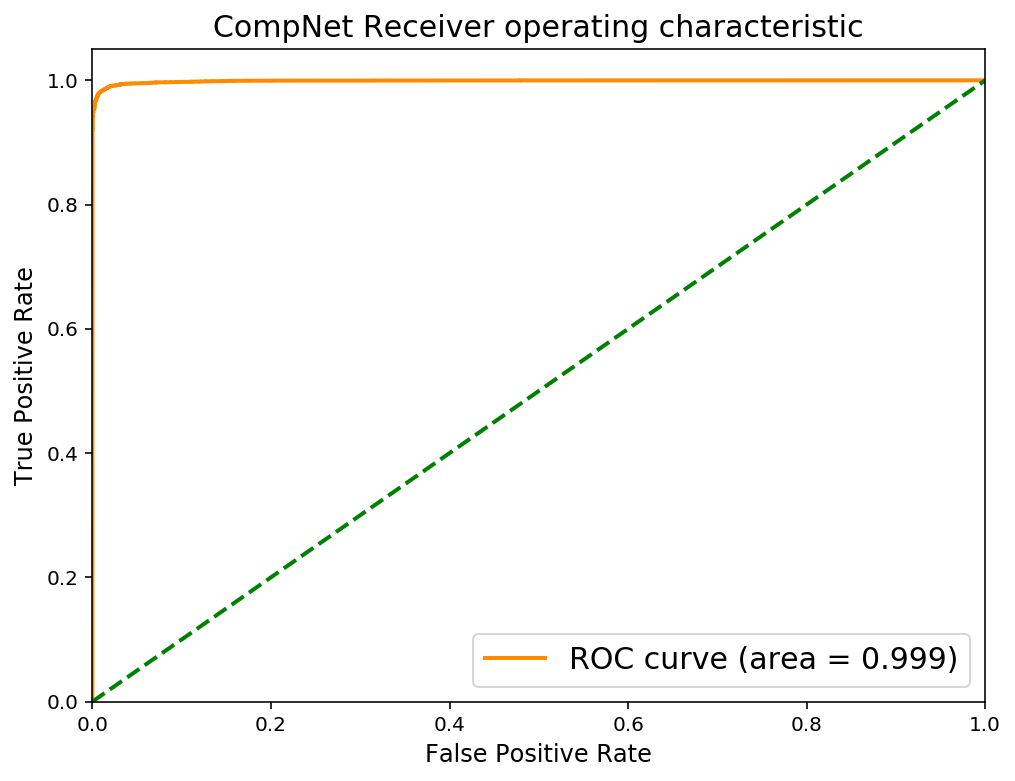

(35.52248140401207,
 131.5724470615387,
 10729.0,
 10538.0,
 88.0,
 279.0,
 677,
 10817)

In [14]:
eval_compnet(ensemble1, train_encoding_ds)

------------------ Evaluation Report ------------------
Total Accuracy: 0.9758675708017551
After 157 batches and 2507 test points

Metrics for the same class:
Avg loss: 0.0724147392442794
Precision: 0.9674764890282131
Recall: 0.9848424411647387
F1 Score: 0.9760822296896619

Metrics for the diff class:
Avg loss: 0.21279423555750757
Precision: 0.9845653939886271
Recall: 0.9668927004387714
F1 Score: 0.9756490239484805


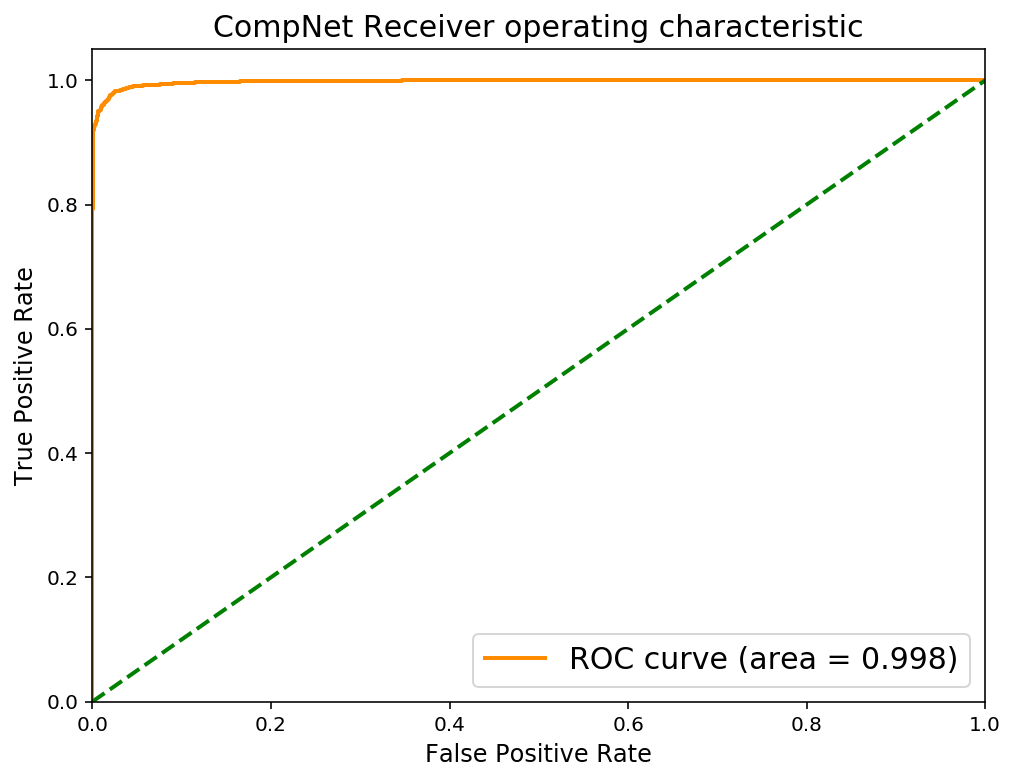

(11.369114061351866, 33.40869498252869, 2469.0, 2424.0, 38.0, 83.0, 157, 2507)

In [15]:
eval_compnet(ensemble1, test_encoding_ds)

## Ensemble CompNets with NNs with increasing depths

In [16]:
ensemble_HP = HyperParameter(lr=0.001, batch_size=16)

In [17]:
ensemble_compnet_diff = [
    nn.Sequential(
        nn.Linear(ensemble_HP.encoding_size, 64),
        nn.LeakyReLU(),
        nn.Linear(64, 1),
        nn.Sigmoid()),
    nn.Sequential(
        nn.Linear(ensemble_HP.encoding_size, 128),
        nn.LeakyReLU(),
        nn.Linear(128, 64),
        nn.LeakyReLU(),
        nn.Linear(64, 1),
        nn.Sigmoid()),
    nn.Sequential(
        nn.Linear(ensemble_HP.encoding_size, 256),
        nn.LeakyReLU(),
        nn.Linear(256, 128),
        nn.LeakyReLU(),
        nn.Linear(128, 64),
        nn.LeakyReLU(),
        nn.Linear(64, 1),
        nn.Sigmoid()),
    nn.Sequential(
        nn.Linear(ensemble_HP.encoding_size, 512),
        nn.LeakyReLU(),
        nn.Linear(512, 256),
        nn.LeakyReLU(),
        nn.Linear(256, 128),
        nn.LeakyReLU(),
        nn.Linear(128, 64),
        nn.LeakyReLU(),
        nn.Linear(64, 1),
        nn.Sigmoid()),
]

## Training the Ensemble 2 CompNets on PointNet 7 Data

In [ ]:
ensemble2 = train_compnet(ensemble_HP, DS, 
                          train_ds=train_encoding_ds,
                          save_wt_fname='pnet_ensemble2.pth',
                          compnet=EnsembleCompNet(comp_net=ensemble_compnet_diff,
                                                 num_ensemble=len(ensemble_compnet_diff))
                         )

## Evaluate the Ensemble 2 CompNets

------------------ Evaluation Report ------------------
Total Accuracy: 0.980909679208653
After 677 batches and 10817 test points

Metrics for the same class:
Avg loss: 0.10620568541774149
Precision: 0.982202447163515
Recall: 0.9795691966349265
F1 Score: 0.9808840546169869

Metrics for the diff class:
Avg loss: 0.17944357667442967
Precision: 0.9796238244514106
Recall: 0.9822501617823796
F1 Score: 0.9809352351936481


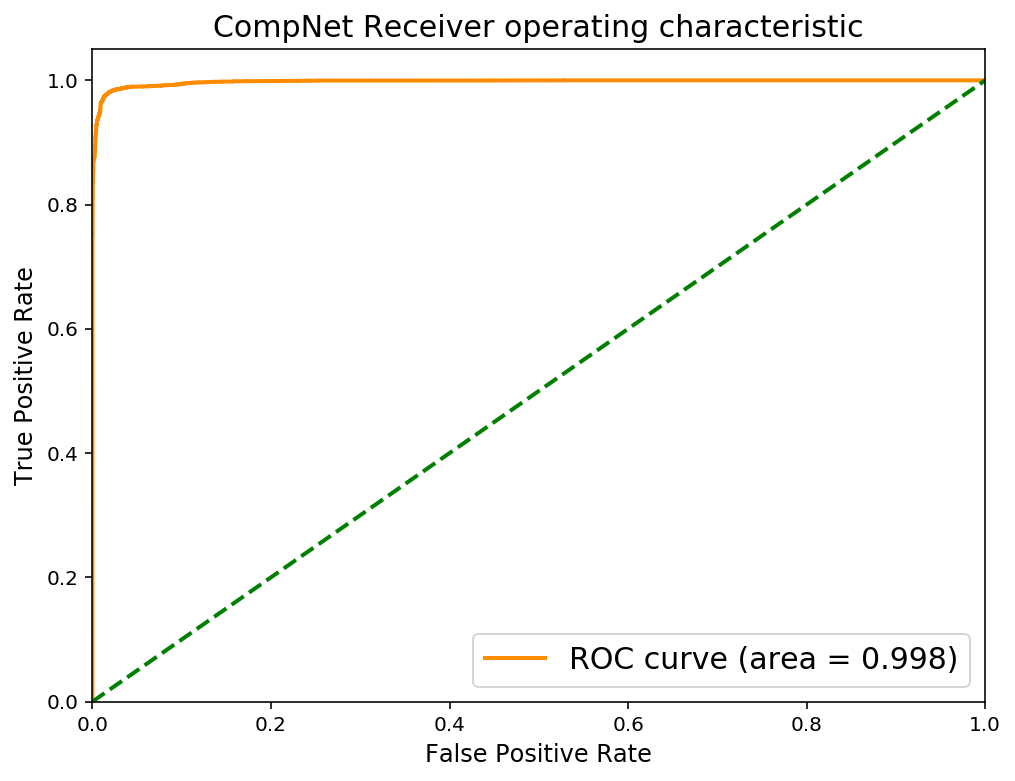

(71.90124902781099,
 121.48330140858889,
 10596.0,
 10625.0,
 221.0,
 192.0,
 677,
 10817)

In [19]:
eval_compnet(ensemble2, train_encoding_ds)

------------------ Evaluation Report ------------------
Total Accuracy: 0.9672915835660152
After 157 batches and 2507 test points

Metrics for the same class:
Avg loss: 0.15188442418577186
Precision: 0.9721886336154776
Recall: 0.9621061029118468
F1 Score: 0.967121090617482

Metrics for the diff class:
Avg loss: 0.19172150556259093
Precision: 0.96249506514015
Recall: 0.9724770642201835
F1 Score: 0.9674603174603175


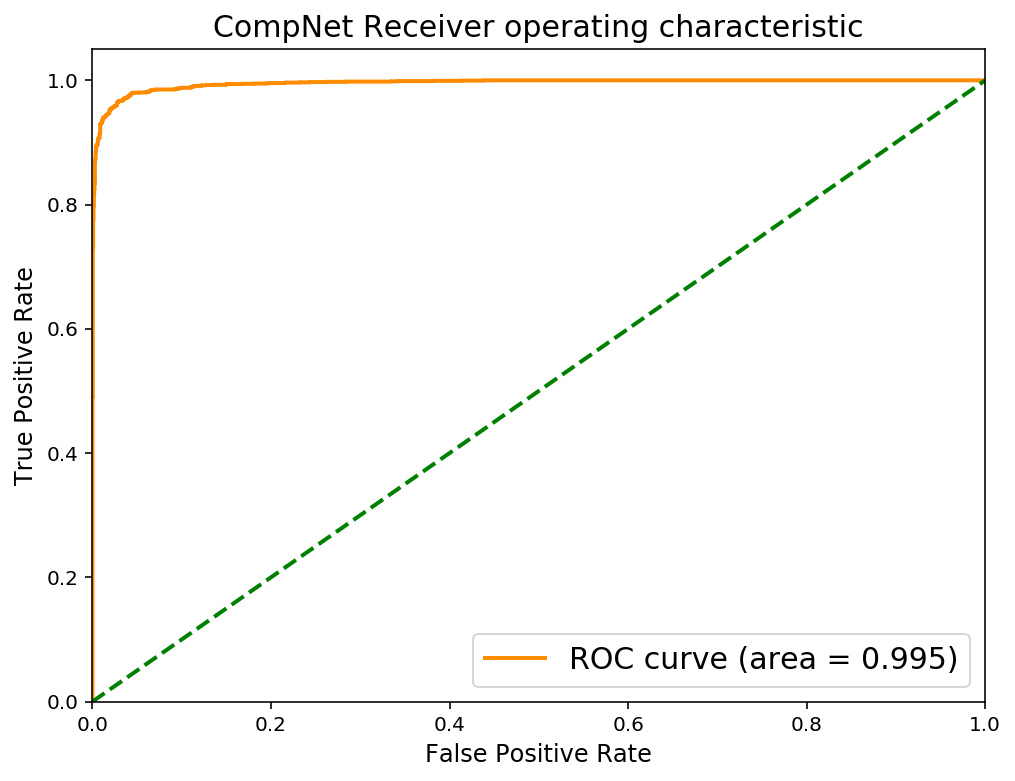

(23.84585459716618, 30.10027637332678, 2412.0, 2438.0, 95.0, 69.0, 157, 2507)

In [23]:
eval_compnet(ensemble2, test_encoding_ds)

## Training the SVM Classifier on the PointNet 7 Data

In [21]:
svm1 = train_svm(HP, DS, train_encoding_ds)

Total Hinge Loss: 0.6806415826939077


## Evaluate the SVM Classifier

In [24]:
eval_svm(svm1, test_encoding_ds)

------------------ Evaluation Report ------------------
After 2507 test points
Total Accuracy: 0.8037495013960909
Total loss 0.6962504986039091

Metrics for the same class:
Precision: 0.7914274779946422
Recall: 0.824890307140008
F1 Score: 0.8078124999999999

Metrics for the diff class:
Precision: 0.8171595168679717
Recall: 0.782608695652174
F1 Score: 0.7995110024449879


(0.6962504986039091, 2068, 1962, 439, 545, 2507)

## Training the Decision Trees Classifier on the PointNet 7 Data

In [25]:
dtree_HP = HyperParameter(batch_size=16)
dtree_HP.criterion = 'entropy'
dtree_HP.min_samples_split = 5
dtree_HP.max_features = 'auto'
dtree_HP.min_samples_leaf = 10

dtree = train_decision_trees(dtree_HP, DS, train_encoding_ds)

Total Log Loss: 0.22462293459293362


## Evaluate the Decision Trees Classifier

------------------ Evaluation Report ------------------
After 2507 test points
Total Accuracy: 0.740127642600718
Total loss 3.2042056200347093

Metrics for the same class:
Precision: 0.754222972972973
Recall: 0.7124052652572797
F1 Score: 0.7327179487179488

Metrics for the diff class:
Precision: 0.7275132275132276
Recall: 0.7678500199441564
F1 Score: 0.7471375897535416


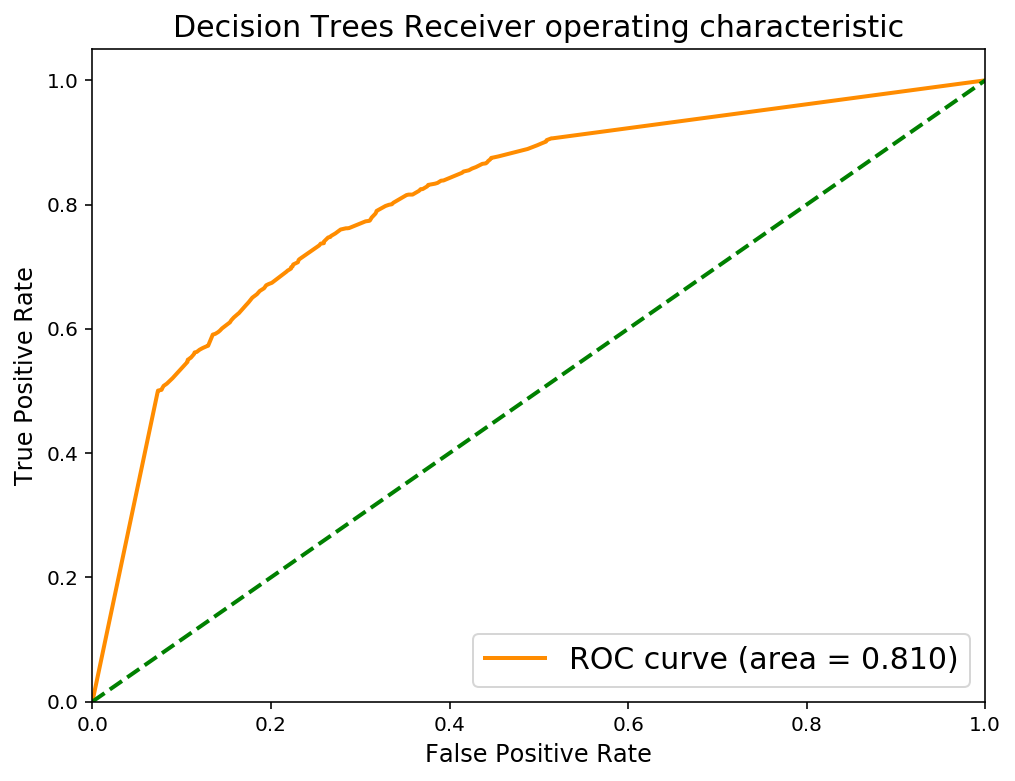

(3.2042056200347093, 1786, 1925, 721, 582, 2507)

In [26]:
eval_decision_trees(dtree, test_encoding_ds)

## Training a Logistic Regression Classifier on the Point Net 7 data

In [27]:
log_reg_HP = HyperParameter(batch_size=16)
log_reg_HP.solver = 'lbfgs'
log_reg = train_log_regr(log_reg_HP, DS, train_encoding_ds)

Total Log Loss: 0.4048531928222308


## Evaluating the Logistic Regression Classifier

------------------ Evaluation Report ------------------
After 2507 test points
Total Accuracy: 0.8035500598324691
Total loss 0.43457562572862685

Metrics for the same class:
Precision: 0.8116298116298116
Recall: 0.7905863581970483
F1 Score: 0.8009698929076581

Metrics for the diff class:
Precision: 0.7958786936236392
Recall: 0.8165137614678899
F1 Score: 0.8060641858633588


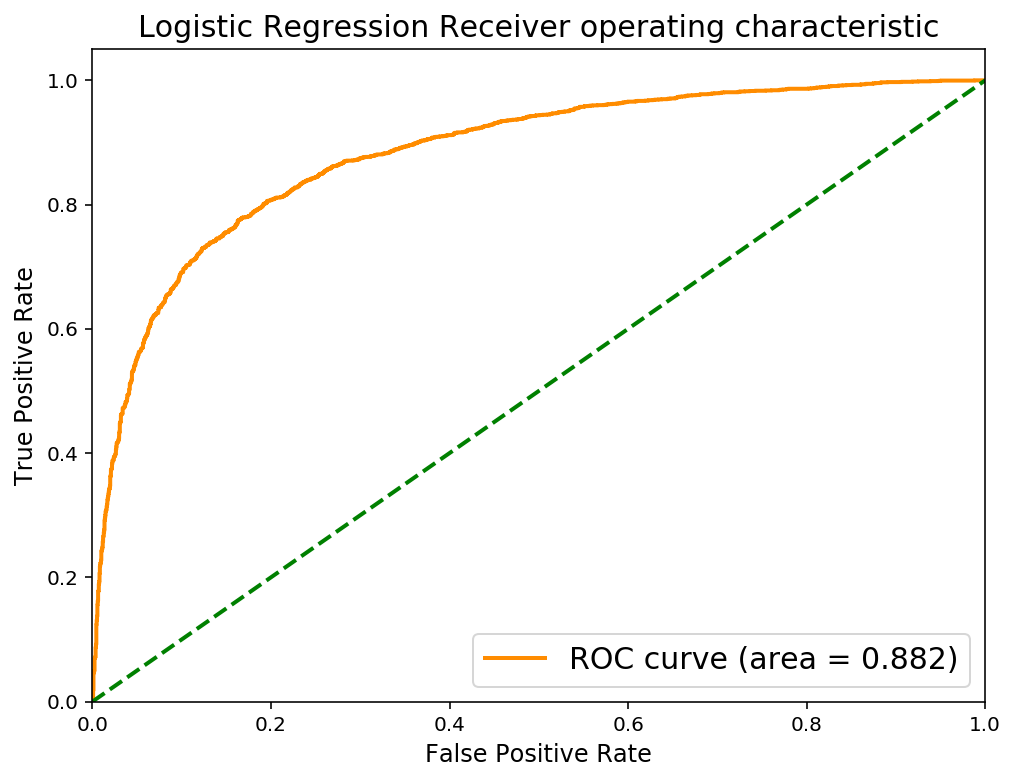

(0.43457562572862685, 1982, 2047, 525, 460, 2507)

In [28]:
eval_log_regr(log_reg, test_encoding_ds)

## Training a Random Forest Classifier on the Point Net 7 data

In [29]:
rand_forest_clf_HP = HyperParameter(batch_size=16)
rand_forest_clf_HP.seed = SEED
rand_forest_clf_HP.max_depth = 3
rand_forest_clf_HP.n_estimators = 100
rand_forest_clf_HP.criterion = 'entropy'
rand_forest_clf_HP.min_samples_split = 10

rand_forest_clf = train_rand_forest(rand_forest_clf_HP, DS, train_encoding_ds)

Total Log Loss: 0.5055780246263262


## Evaluating the Random Forest Classifier

------------------ Evaluation Report ------------------
After 2507 test points
Total Accuracy: 0.7967690466693259
Total loss 0.5114612679655473

Metrics for the same class:
Precision: 0.7877030162412993
Recall: 0.8125249301954527
F1 Score: 0.7999214608285884

Metrics for the diff class:
Precision: 0.8064250411861614
Recall: 0.781013163143199
F1 Score: 0.793515704154002


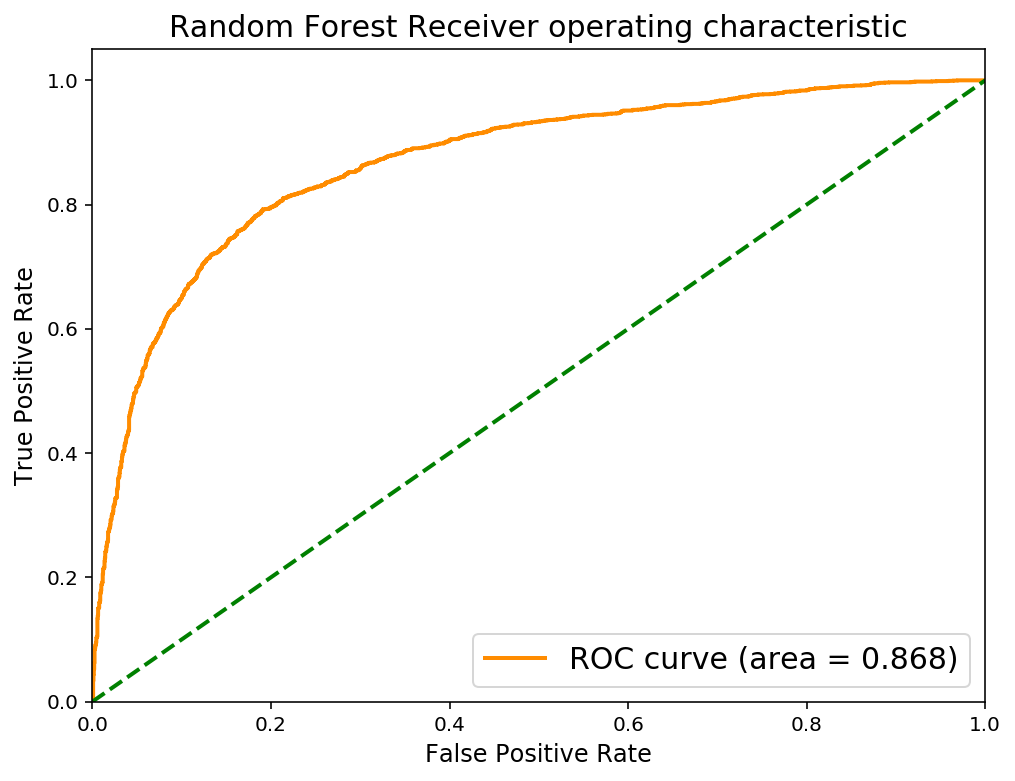

(0.5114612679655473, 2037, 1958, 470, 549, 2507)

In [30]:
eval_rand_forest(rand_forest_clf, test_encoding_ds)

## Training a Naive Bayes Classifier on the Point Net 7 data

In [31]:
nb_clf = train_naive_bayes(HP, DS, train_encoding_ds)

Total Loss: 3.614567820260264


## Evaluating the Naive Bayes Classifier

------------------ Evaluation Report ------------------
After 2507 test points
Total Accuracy: 0.7782209812524931
Total loss 3.646034268527959

Metrics for the same class:
Precision: 0.7623166603986461
Recall: 0.8085360989230156
F1 Score: 0.7847464188927603

Metrics for the diff class:
Precision: 0.7961783439490446
Recall: 0.7479058635819705
F1 Score: 0.7712875359934184


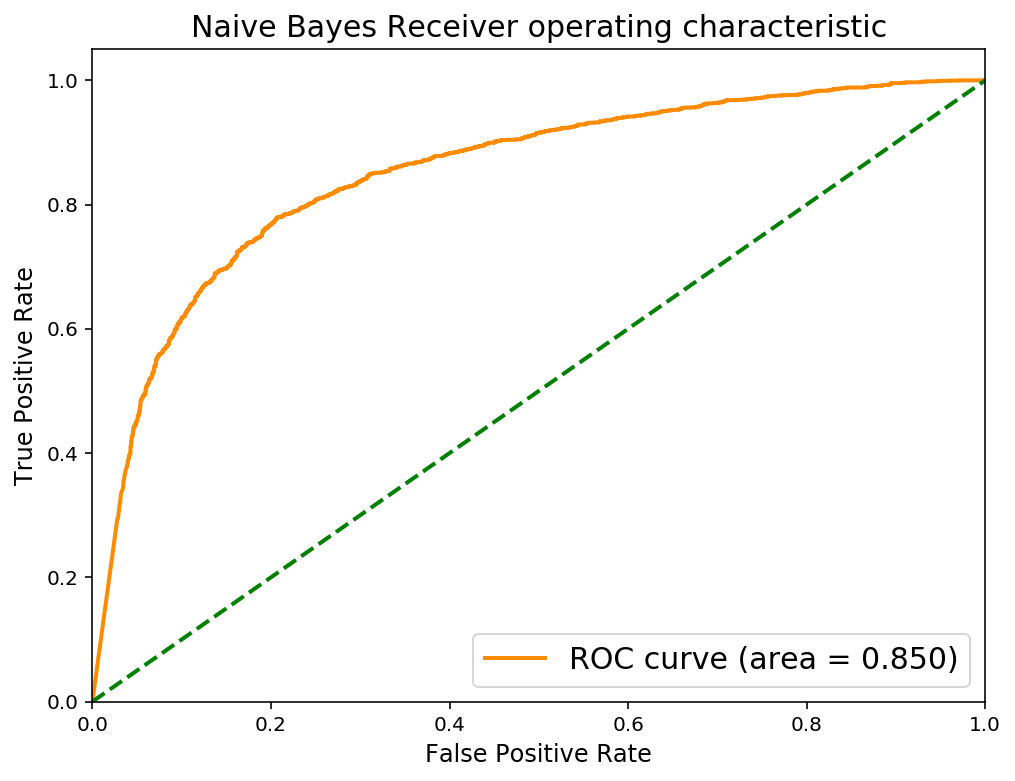

(3.646034268527959, 2027, 1875, 480, 632, 2507)

In [32]:
eval_gaussian_naive_bayes(nb_clf, test_encoding_ds)